Documentación pyedflib: https://pyedflib.readthedocs.io/en/latest/ref/edfreader.html  
Documentación networkx: https://networkx.org/documentation/stable/reference/introduction.html  
Información grafos: https://www.cienciadedatos.net/documentos/pygml01-introduccion-grafos-redes-python.html  
Información mne: https://mne.tools/stable/index.html  

In [3]:
import mne
import pyedflib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from os.path import basename
from pprint import pprint
from matplotlib.patches import Circle
from matplotlib.colors import LinearSegmentedColormap

CHANNELS: tuple[str] = ('Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'T3', 'T4', 
                        'C3', 'C4', 'T5', 'T6', 'P3', 'P4', 'O1', 'O2', 
                        'Fz', 'Cz', 'Pz')
N_CHANNELS: int = len(CHANNELS)

df_subject_info = pd.read_csv('Archivos\subject-info.csv')[['Subject', 'Count quality']]

# Posición aproximada de los electrodos en la cabeza
pos = {
    'Fp1': (-0.300, 0.954), 'Fp2': (0.300, 0.954),
    'F3': (-0.400, 0.510), 'F4': (0.400, 0.510),
    'F7': (-0.800, 0.600), 'F8': (0.800, 0.600),
    'T3': (-1.000, 0.000), 'T4': (1.000, 0.000),
    'C3': (-0.500, 0.000), 'C4': (0.500, 0.000),
    'T5': (-0.800, -0.600), 'T6': (0.800, -0.600),
    'P3': (-0.400, -0.510), 'P4': (0.400, -0.510),
    'O1': (-0.300, -0.954), 'O2': (0.300, -0.954),
    'Fz': (0.000, 0.500), 'Cz': (0.000, 0.000),
    'Pz': (0.000, -0.500)
}

In [4]:
# Convertir un archivo EDF a CSV

def edf_to_csv(filename: str, output_path: str = '') -> None:
    # Se guardan los archivos en una matriz 19 x No. Señales (31000 o 91000)

    f: pyedflib.EdfReader = pyedflib.EdfReader(filename)
    
    signals: np.zeros = np.zeros((N_CHANNELS + 1, m := f.getNSamples()[0]))
    signals[0, :] = np.arange(1, m + 1) # Es la cabecera de las columnas que son numeros desde el 1 al No. Señales
    for i in np.arange(1, N_CHANNELS + 1):
        signals[i, :]= f.readSignal(i - 1)

    np.savetxt(output_path + basename(filename.replace('.edf', '.csv')), signals, delimiter=';')

    f.close()

In [5]:
# Funciones a partir de la ruta

def get_distances(path: str) -> pd.DataFrame:
    df: pd.DataFrame = pd.read_csv(path, sep=';')

    df = np.transpose(df)
    df.columns = CHANNELS

    # Hacer la matriz de correlación
    df_correlation: pd.DataFrame = df.corr()

    # Obtener las listas de las distancias a partir de las correlaciones
    # Dij = sqrt(2 * (1 - Cij))
    df_distances: pd.DataFrame = pd.DataFrame(np.sqrt(2 * (1 - df_correlation)), index=CHANNELS, columns=CHANNELS)

    return df_distances

def get_graph(path: str) -> nx.Graph:
    df_distances: pd.DataFrame = get_distances(path)

    edges = df_distances.stack().reset_index()
    edges.columns = ["target", "source", "weight"]
    edges = edges.loc[edges["target"] != edges["source"]].copy()

    # Quitar las columnas repetidas
    edges['sorted_columns'] = np.sort(edges[['target', 'source']], axis=1).tolist()
    edges.drop_duplicates(subset='sorted_columns', keep='first', inplace=True)
    edges.drop('sorted_columns', axis=1, inplace=True)

    g0 = nx.from_pandas_edgelist(edges, "target", "source", edge_attr=["weight"])

    return g0

def get_mst(path: str) -> nx.Graph:
    return nx.minimum_spanning_tree(get_graph(path))

def centrality(path: str) -> pd.DataFrame:
    mst_g0 = get_mst(path)

    degree_centrality = nx.degree_centrality(mst_g0)
    betweenness_centrality = nx.betweenness_centrality(mst_g0)
    closeness_centrality = nx.closeness_centrality(mst_g0)
    pagerank = nx.pagerank(mst_g0, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)

    return pd.DataFrame({
        'nodes': CHANNELS,
        'degree': degree_centrality.values(),
        'betweenness': betweenness_centrality.values(),
        'closeness': closeness_centrality.values(),
        'pagerank': pagerank.values()
    })

In [6]:
# Funciones a partir de la matriz de distancias

def get_graph_from_df(df_distances: pd.DataFrame) -> nx.Graph:
    edges = df_distances.stack().reset_index()
    edges.columns = ["target", "source", "weight"]
    edges = edges.loc[edges["target"] != edges["source"]].copy()

    # Quitar las columnas repetidas
    edges['sorted_columns'] = np.sort(edges[['target', 'source']], axis=1).tolist()
    edges.drop_duplicates(subset='sorted_columns', keep='first', inplace=True)
    edges.drop('sorted_columns', axis=1, inplace=True)

    g0 = nx.from_pandas_edgelist(edges, "target", "source", edge_attr=["weight"])

    return g0

def get_mst_from_df(df_distances: pd.DataFrame) -> nx.Graph:
    return nx.minimum_spanning_tree(get_graph_from_df(df_distances))

def get_centrality_from_df(df_distances: pd.DataFrame) -> pd.DataFrame:
    mst_g0 = get_mst_from_df(df_distances)

    degree_centrality = nx.degree_centrality(mst_g0)
    betweenness_centrality = nx.betweenness_centrality(mst_g0)
    closeness_centrality = nx.closeness_centrality(mst_g0)
    pagerank = nx.pagerank(mst_g0, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)

    return pd.DataFrame({
        'nodes': CHANNELS,
        'degree': degree_centrality.values(),
        'betweenness': betweenness_centrality.values(),
        'closeness': closeness_centrality.values(),
        'pagerank': pagerank.values()
    })

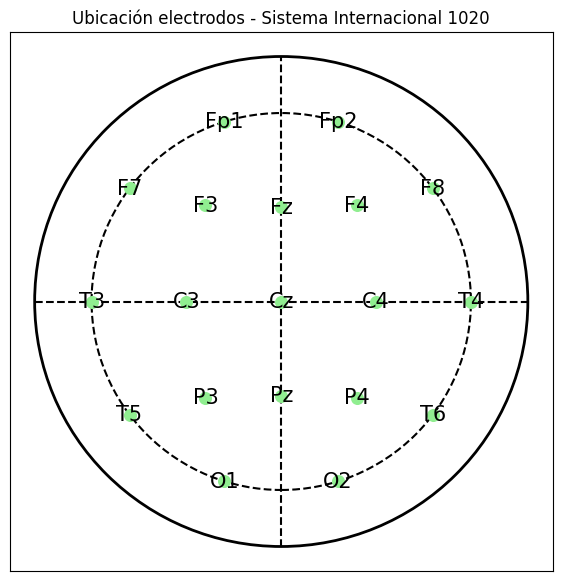

In [8]:
# Hacer una gráfica donde se vea la ubicación de los nodos (No es exacta - El montaje del sistema 1020)

fig, ax = plt.subplots(figsize=(7, 7))

ax.add_patch(Circle((0, 0), radius=1, color='black', fill=False, linestyle='--', linewidth=1.5))
ax.add_patch(Circle((0, 0), radius=1.3, color='black', fill=False, linewidth=2))

# Agregar segmentos
ax.plot([0, 0], [-1.3, 1.3], linestyle='--', color='black', linewidth=1.5)
ax.plot([-1.3, 1.3], [0, 0], linestyle='--', color='black', linewidth=1.5)

G = nx.Graph()
G.add_nodes_from(CHANNELS)

nx.draw_networkx(
    G,
    pos,
    node_size=70,
    with_labels=True,
    font_size=15,
    node_color='lightgreen'
)

ax.set_title('Ubicación electrodos - Sistema Internacional 1020')
plt.show()

# Ejemplo

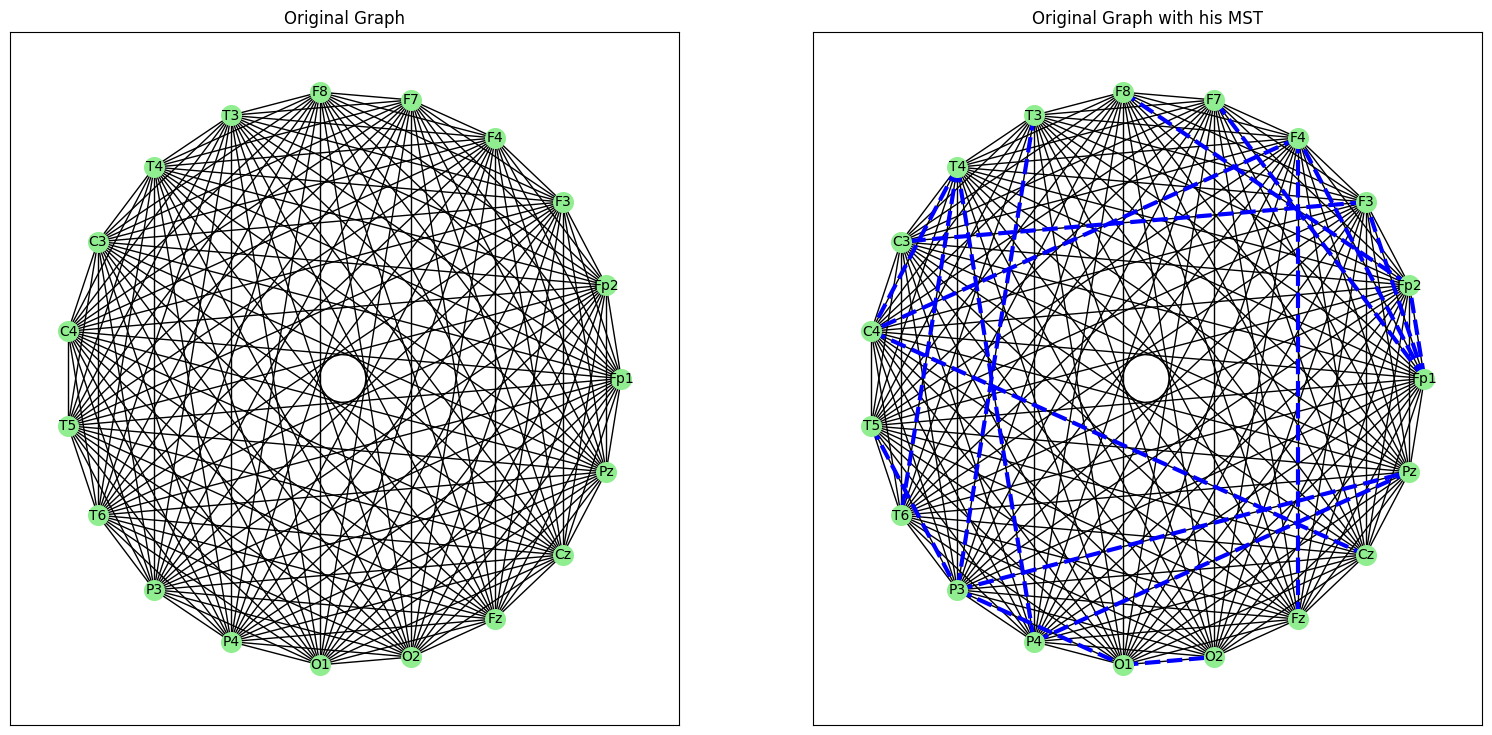

In [73]:
# mst sujeto00 antes

g0 = get_graph('Archivos\\Subject00\\csv\\Subject00_1.csv')
mst_g0 = nx.minimum_spanning_tree(g0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 9))

# Dibujar el grafo original
ax1.set_title('Original Graph')
nx.draw_networkx(
    g0, pos=nx.circular_layout(g0), with_labels=True, 
    node_size=200, node_color="lightgreen", 
    font_size=10, font_color="black",
    ax=ax1
)

# Dibujar la MST del grafo original
ax2.set_title("Original Graph with his MST")

nx.draw_networkx(
    g0, pos=nx.circular_layout(g0), with_labels=True, 
    node_size=200, node_color="lightgreen", 
    font_size=10, font_color="black",
    ax=ax2
)

# Dibujarle las lineas de las aristas
edges_mst = [(u, v) for u, v in mst_g0.edges]
nx.draw_networkx_edges(
    mst_g0, pos=nx.circular_layout(g0), edgelist=edges_mst,
    edge_color="blue", style="dashed", width=3,
    ax=ax2
)

plt.show()

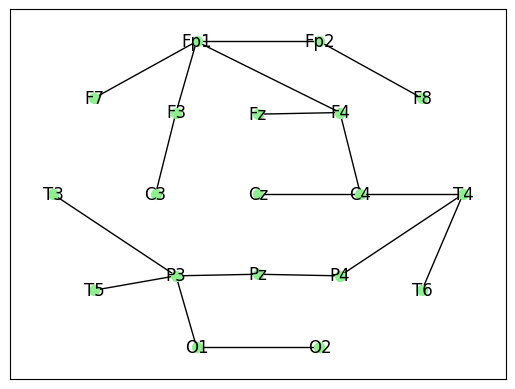

In [75]:
mst_g1 = get_mst('Archivos\\Subject00\\csv\\Subject00_1.csv')
nx.draw_networkx(
    mst_g1,
    pos,
    node_size=50,
    node_color='lightgreen'
)

In [23]:
density = nx.density(mst_g0)
ave_clustering = nx.average_clustering(mst_g0)

print(f'Density: {density}')
print(f'Average clustering: {ave_clustering}\n')

degree_centrality = nx.degree_centrality(mst_g0)
print('Degree centrality:')
pprint(sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

betweenness_centrality = nx.betweenness_centrality(mst_g0)
print('\nBetweenness centrality')
pprint(sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

closeness_centrality = nx.closeness_centrality(mst_g0)
print('\nClossenes centrality')
pprint(sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

pagerank = nx.pagerank(mst_g0, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)
print('\nPagerank')
pprint(sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5])

Density: 0.10526315789473684
Average clustering: 0.0

Degree centrality:
[('Fp1', 0.2222222222222222),
 ('P3', 0.2222222222222222),
 ('F4', 0.16666666666666666),
 ('T4', 0.16666666666666666),
 ('C4', 0.16666666666666666)]

Betweenness centrality
[('C4', 0.5816993464052288),
 ('T4', 0.5686274509803921),
 ('F4', 0.542483660130719),
 ('Fp1', 0.477124183006536),
 ('P4', 0.47058823529411764)]

Clossenes centrality
[('C4', 0.32142857142857145),
 ('T4', 0.3157894736842105),
 ('F4', 0.3050847457627119),
 ('P4', 0.2903225806451613),
 ('Fp1', 0.2727272727272727)]

Pagerank
[('P3', 0.10972118843902842),
 ('Fp1', 0.09441549482198572),
 ('C4', 0.08446214111230474),
 ('T4', 0.07367667841667408),
 ('F4', 0.07143403418226048)]


In [24]:
# Datos para sacar los diagrama de barras para cada medida de centralidad
df_centrality = pd.DataFrame({
    'nodes': CHANNELS,
    'degree': degree_centrality.values(),
    'betweenness': betweenness_centrality.values(),
    'closeness': closeness_centrality.values(),
    'pagerank': pagerank.values()
})

df_centrality

nodes    degree  betweenness  closeness  pagerank
0    Fp1  0.222222     0.477124   0.272727  0.094415
1    Fp2  0.111111     0.111111   0.222222  0.053917
2     F3  0.111111     0.111111   0.222222  0.054822
3     F4  0.166667     0.542484   0.305085  0.071434
4     F7  0.055556     0.000000   0.216867  0.040555
5     F8  0.055556     0.000000   0.183673  0.037525
6     T3  0.055556     0.000000   0.189474  0.038682
7     T4  0.166667     0.568627   0.315789  0.073677
8     C3  0.055556     0.000000   0.183673  0.038422
9     C4  0.166667     0.581699   0.321429  0.084462
10    T5  0.055556     0.000000   0.189474  0.032426
11    T6  0.055556     0.000000   0.243243  0.028409
12    P3  0.222222     0.398693   0.230769  0.109721
13    P4  0.111111     0.470588   0.290323  0.049739
14    O1  0.111111     0.111111   0.193548  0.058629
15    O2  0.055556     0.000000   0.163636  0.034226
16    Fz  0.055556     0.000000   0.236842  0.020942
17    Cz  0.055556     0.000000   0.246575  0.033943
18    Pz  0.111111     0.424837   0.260870  0.044052

# Medidas de centralidad para todos los participantes - Antes y durante

In [144]:
# Guarda las medidas de centralidad de los sujetos (antes y despues) en archivos

df_before = pd.DataFrame()
df_during = pd.DataFrame()

for i in range(0, 35 + 1):
    subject = f'Subject{i:02}'
    csv_path1 = f'Archivos\\{subject}\\csv\\{subject}_1.csv'
    csv_path2 = f'Archivos\\{subject}\\csv\\{subject}_2.csv'

    df_temp1 = pd.DataFrame({'subject': [subject]*19})
    df_temp1 = pd.concat([df_temp1, centrality(csv_path1)], axis=1)
    df_temp1['count_quality'] = ('G' if df_subject_info["Count quality"][i] == 1 else 'B')
    df_before = pd.concat([df_before, df_temp1], ignore_index=True)

    df_temp2 = pd.DataFrame({'subject': [subject]*19})
    df_temp2 = pd.concat([df_temp2, centrality(csv_path2)], axis=1)
    df_temp2['count_quality'] = ('G' if df_subject_info["Count quality"][i] == 1 else 'B')
    df_during = pd.concat([df_during, df_temp2], ignore_index=True)

df_before.to_csv('Archivos\centrality_before.csv', sep=';', index=False)
df_during.to_csv('Archivos\centrality_during.csv', sep=';', index=False)

In [6]:
df_before = pd.read_csv('Archivos\centrality_before.csv', delimiter=';')
df_before['state'] = 'before'

df_during = pd.read_csv('Archivos\centrality_during.csv', delimiter=';')
df_during['state'] = 'during'

df_result = pd.concat([df_before, df_during], ignore_index=True)
df_result

subject nodes    degree  betweenness  closeness  pagerank  \
0     Subject00   Fp1  0.222222     0.477124   0.272727  0.094415   
1     Subject00   Fp2  0.111111     0.111111   0.222222  0.053917   
2     Subject00    F3  0.111111     0.111111   0.222222  0.054822   
3     Subject00    F4  0.166667     0.542484   0.305085  0.071434   
4     Subject00    F7  0.055556     0.000000   0.216867  0.040555   
...         ...   ...       ...          ...        ...       ...   
1363  Subject35    O1  0.111111     0.366013   0.240000  0.047850   
1364  Subject35    O2  0.111111     0.294118   0.209302  0.046602   
1365  Subject35    Fz  0.222222     0.398693   0.240000  0.094460   
1366  Subject35    Cz  0.111111     0.529412   0.300000  0.040156   
1367  Subject35    Pz  0.055556     0.000000   0.155172  0.027817   

     count_quality   state  
0                B  before  
1                B  before  
2                B  before  
3                B  before  
4                B  before  
...            ...     ...  
1363             G  during  
1364             G  during  
1365             G  during  
1366             G  during  
1367             G  during  

[1368 rows x 8 columns]

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

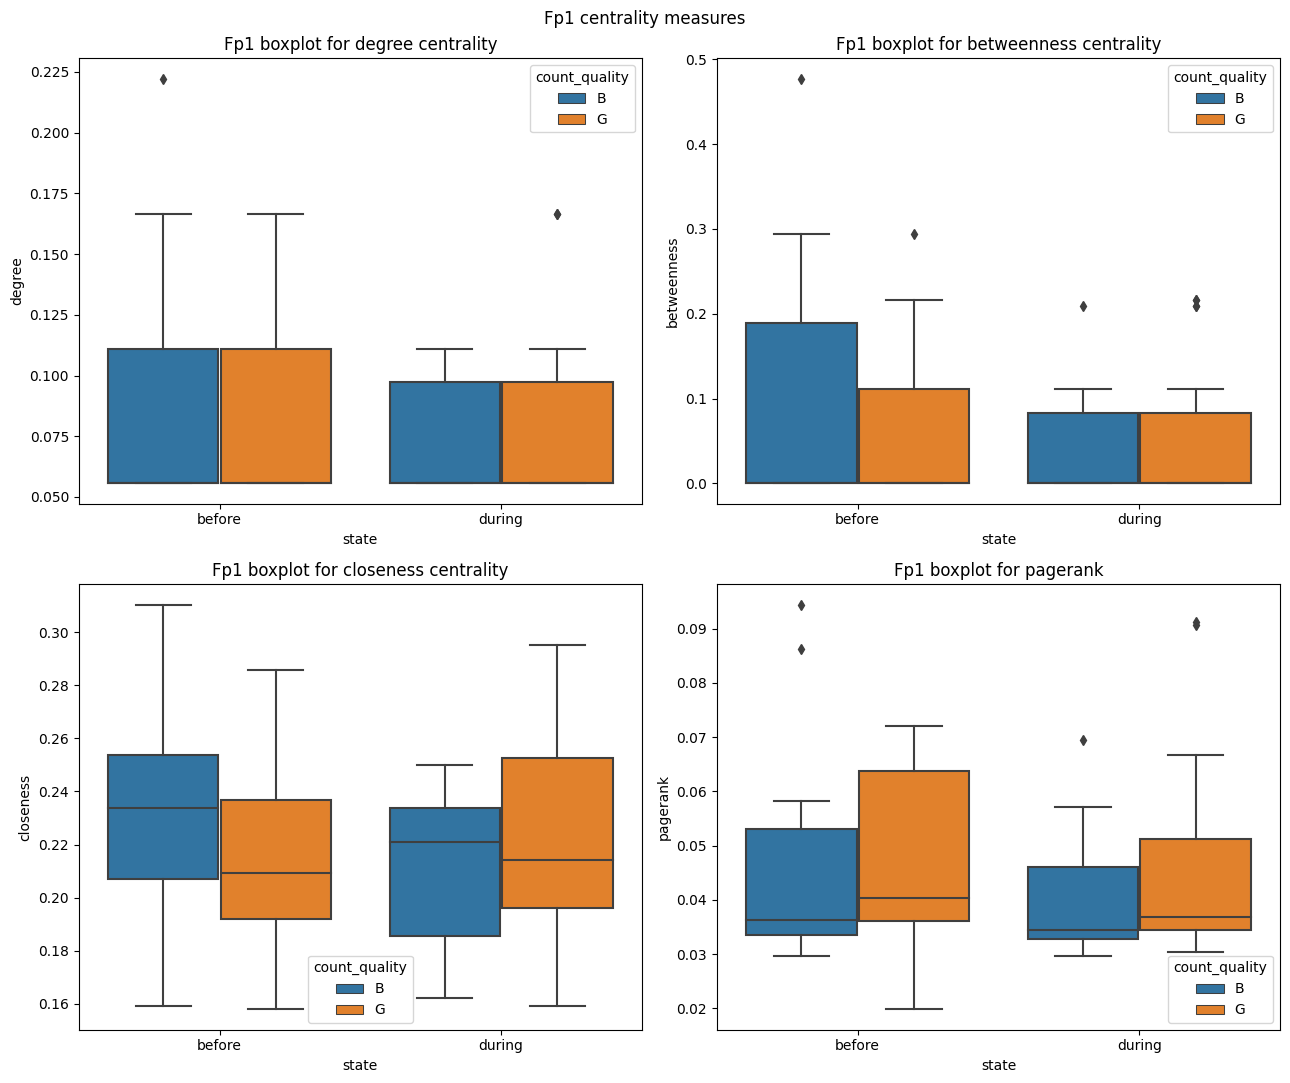

In [8]:
# Todas las gráficas de Fp1 para cada métrica diferente
sensor: str = 'Fp1'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()
plt.show()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

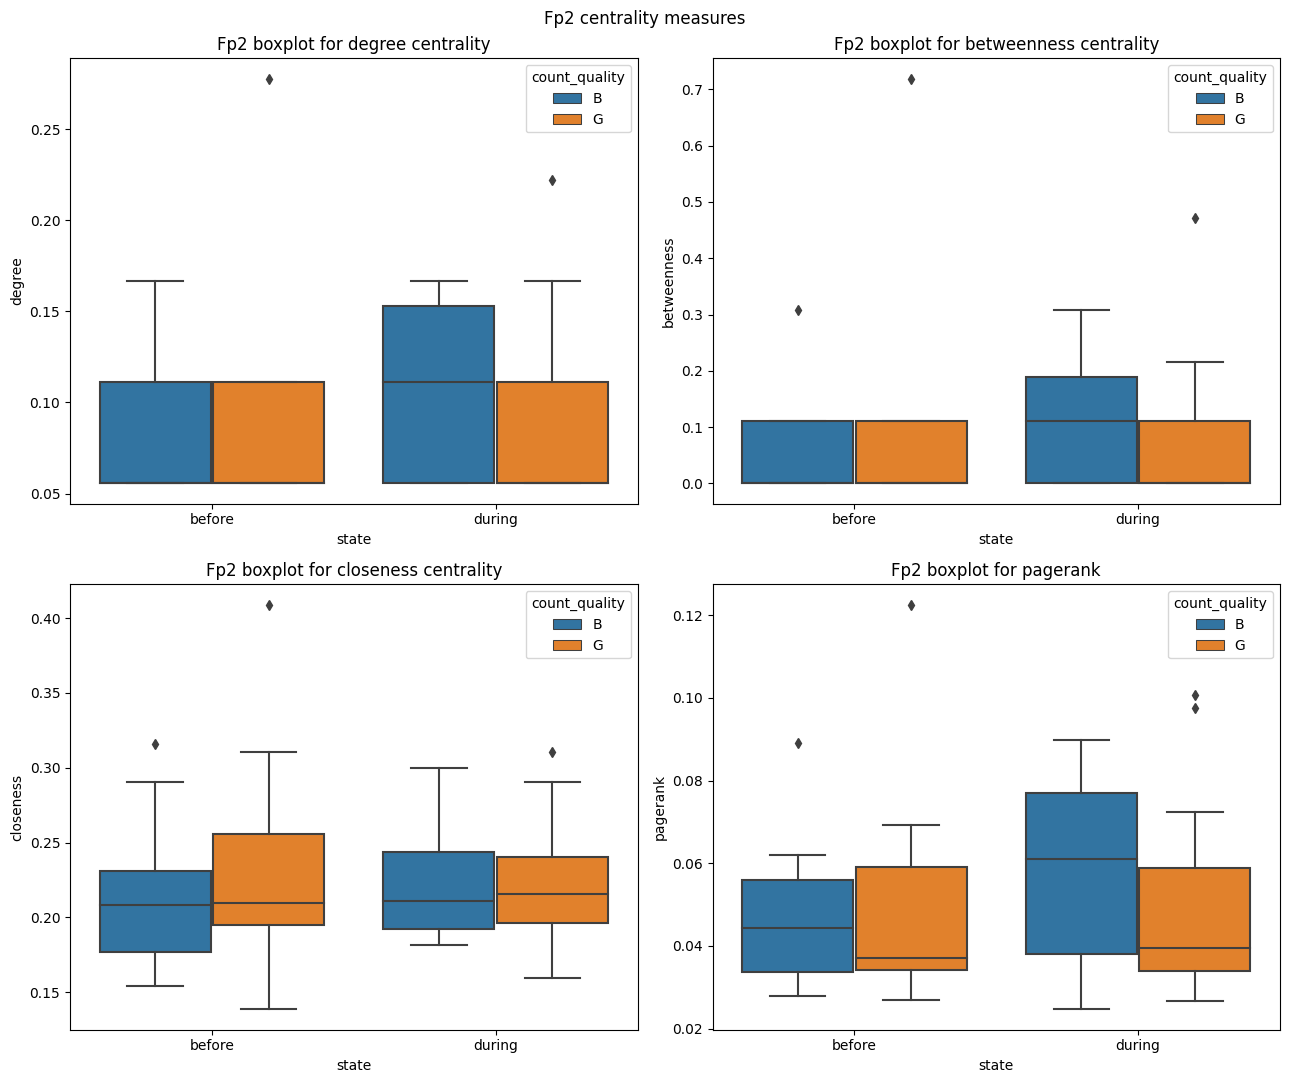

In [147]:
# Todas las gráficas de Fp2 para cada métrica diferente
sensor: str = 'Fp2'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

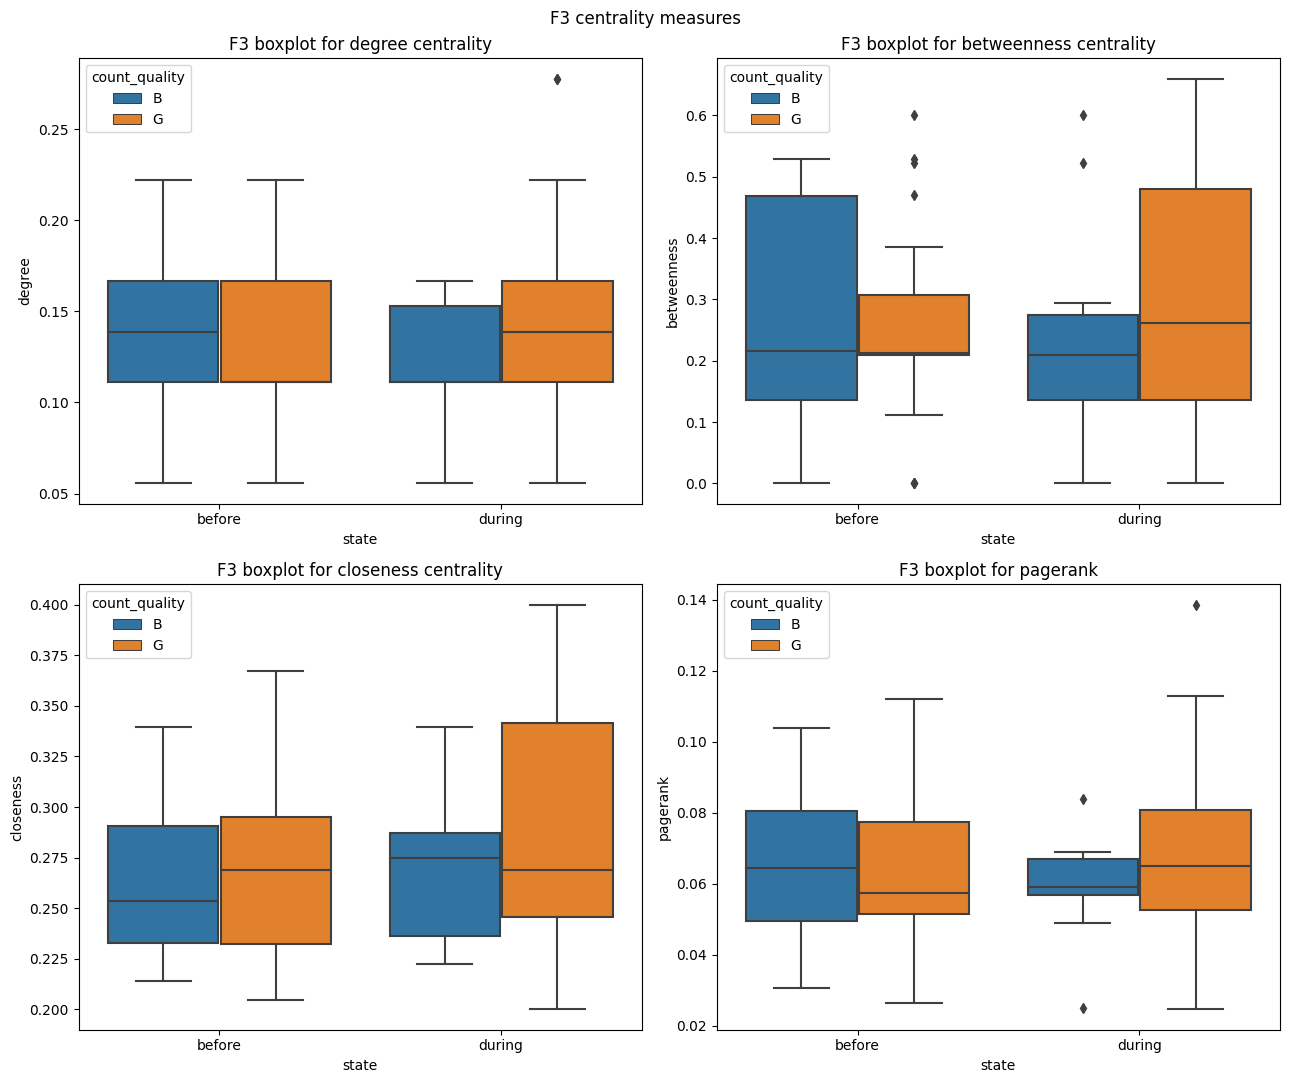

In [148]:
# Todas las gráficas de F3 para cada métrica diferente
sensor: str = 'F3'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

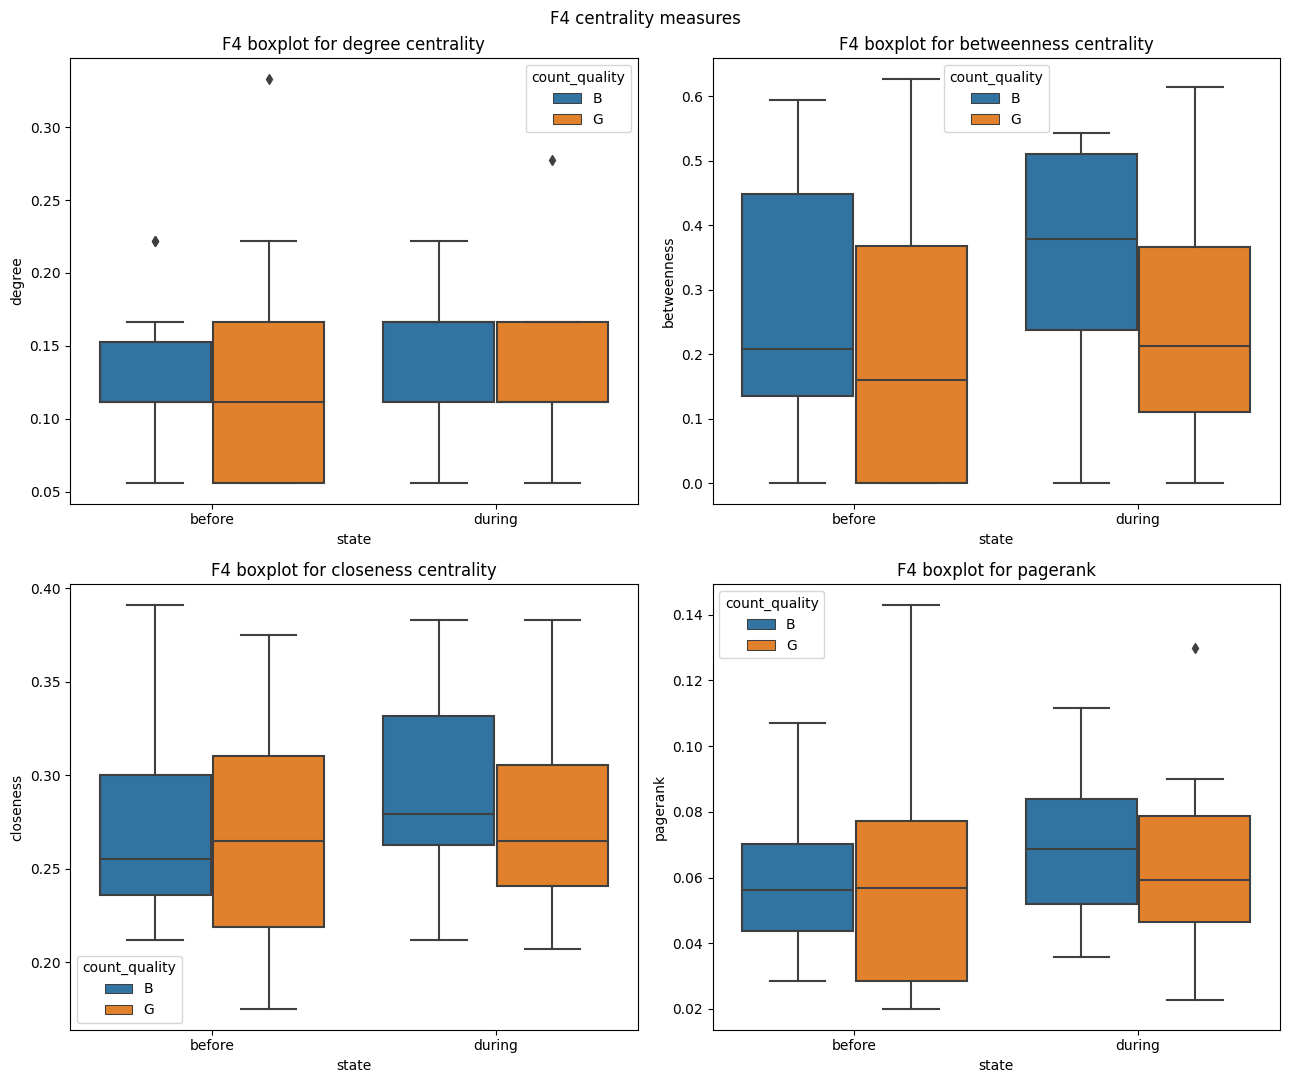

In [149]:
# Todas las gráficas de F4 para cada métrica diferente
sensor: str = 'F4'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

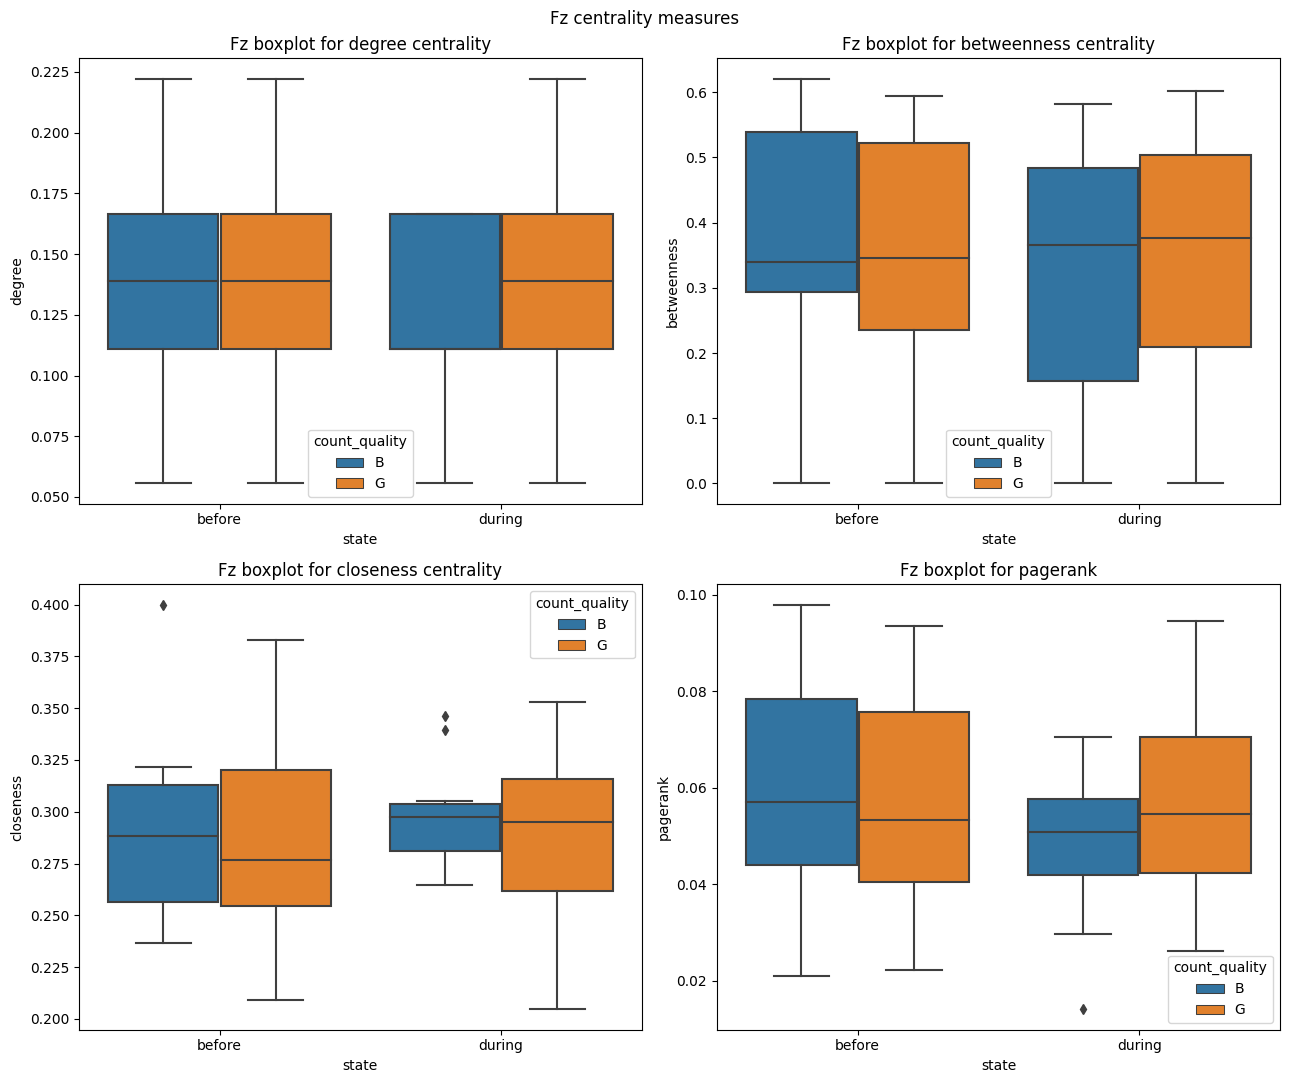

In [150]:
# Todas las gráficas de Fz para cada métrica diferente
sensor: str = 'Fz'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

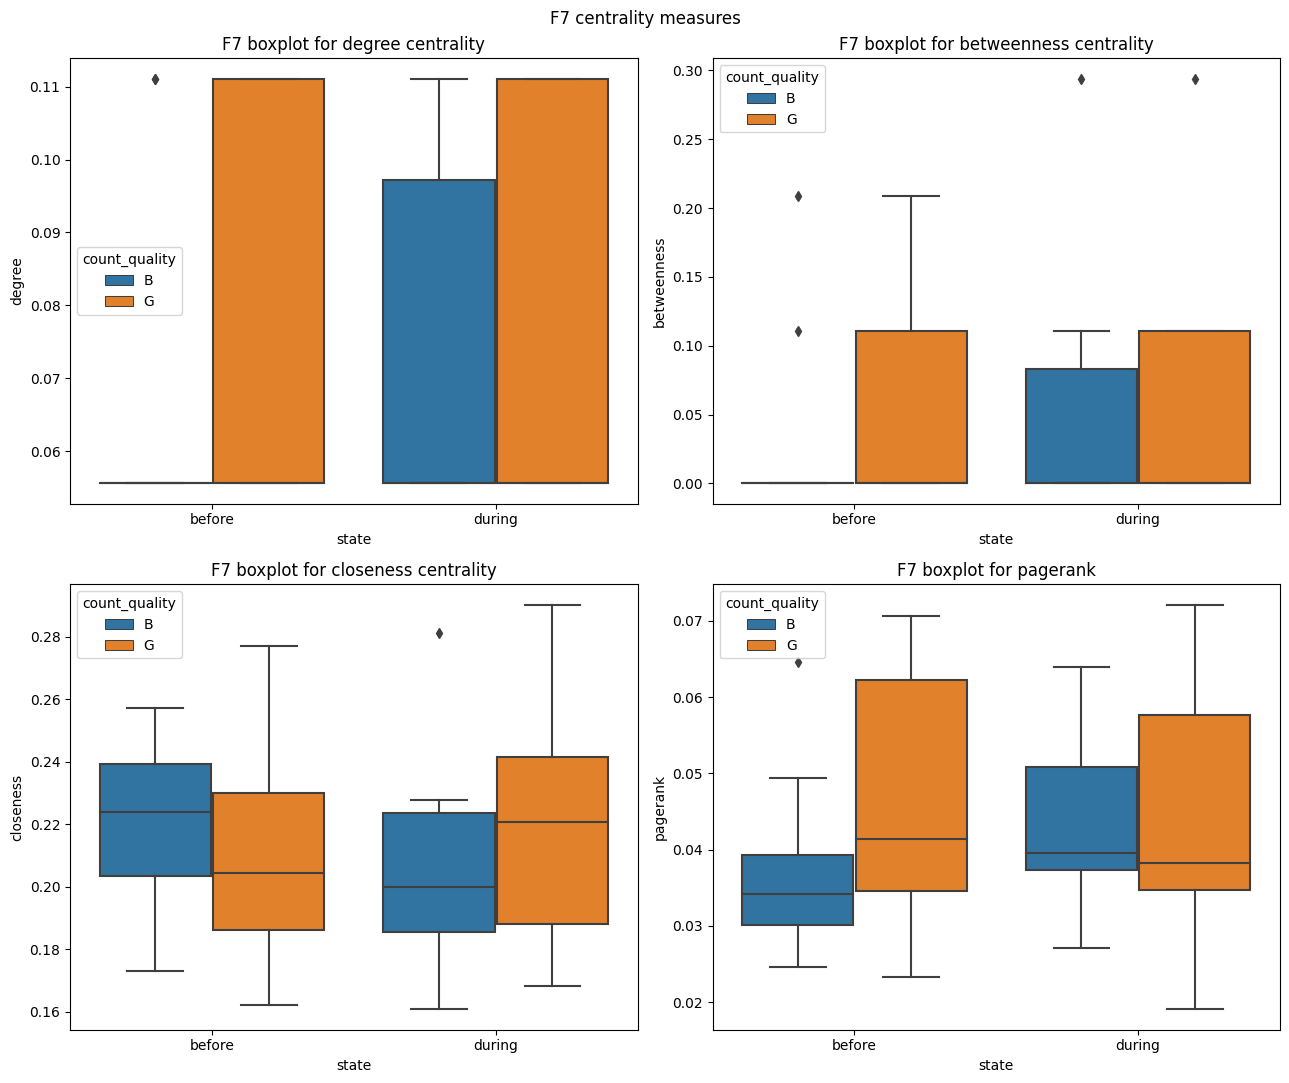

In [151]:
# Todas las gráficas de F7 para cada métrica diferente
sensor: str = 'F7'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

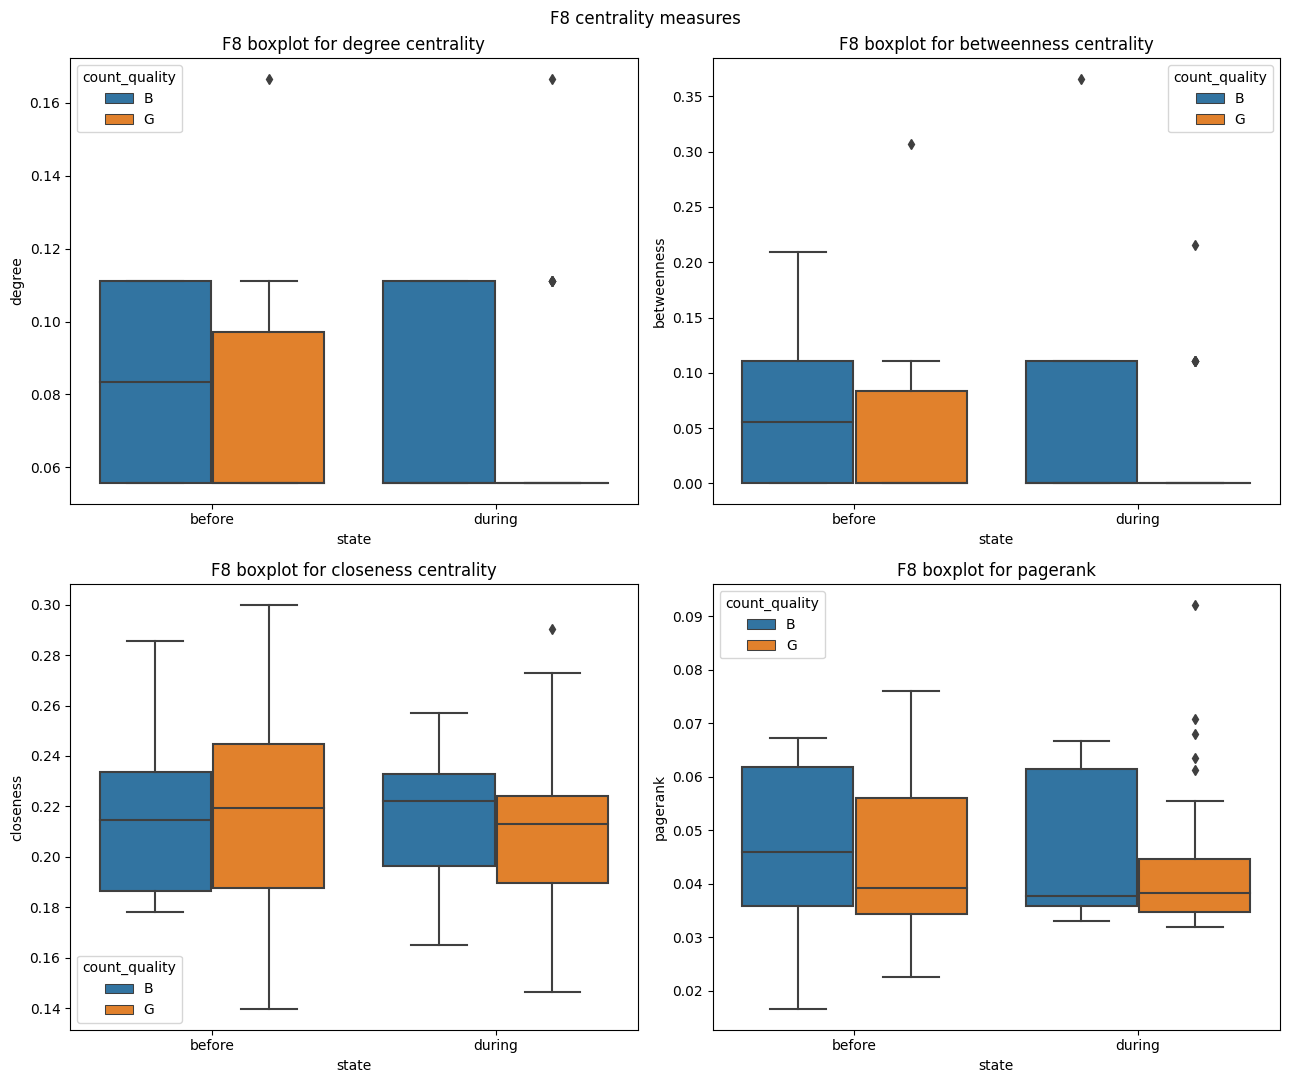

In [152]:
# Todas las gráficas de F8 para cada métrica diferente
sensor: str = 'F8'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

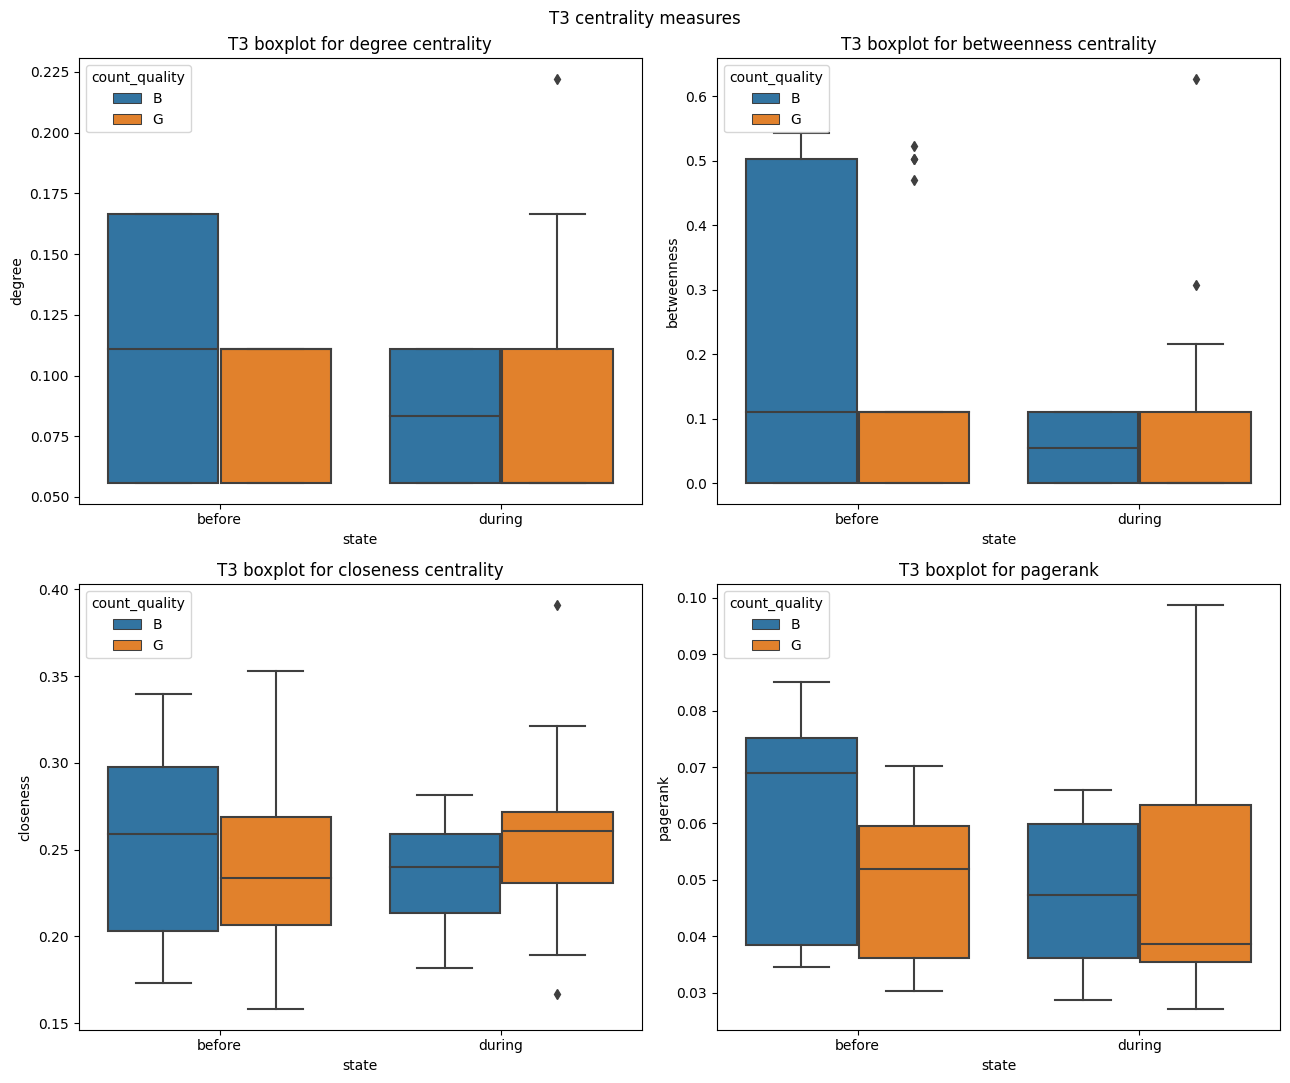

In [153]:
# Todas las gráficas de T3 para cada métrica diferente
sensor: str = 'T3'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

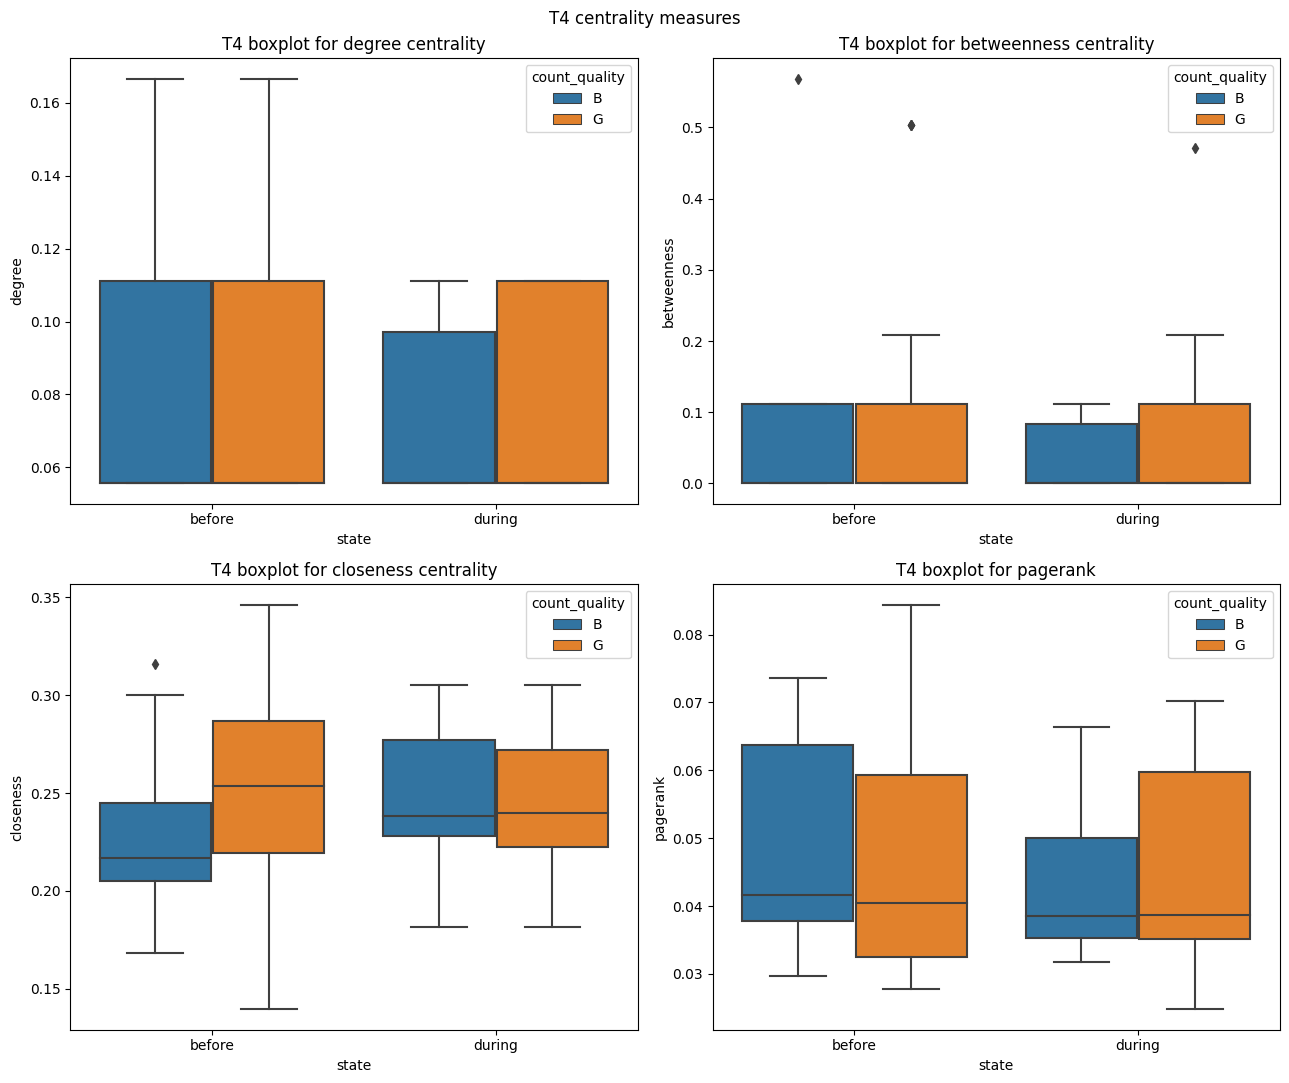

In [154]:
# Todas las gráficas de T4 para cada métrica diferente
sensor: str = 'T4'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

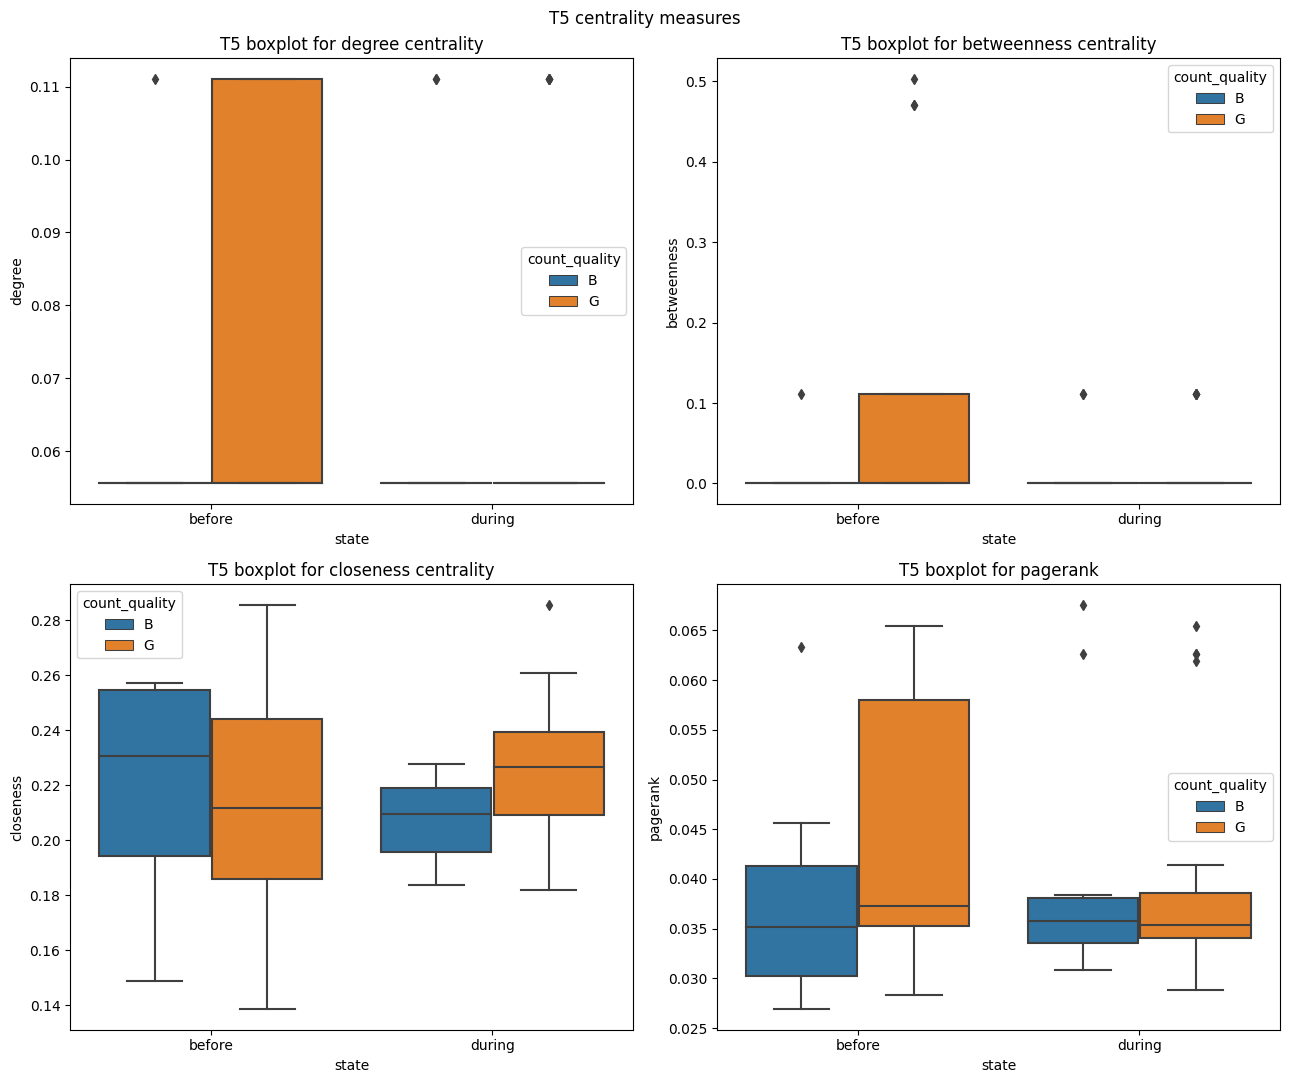

In [155]:
# Todas las gráficas de T5 para cada métrica diferente
sensor: str = 'T5'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

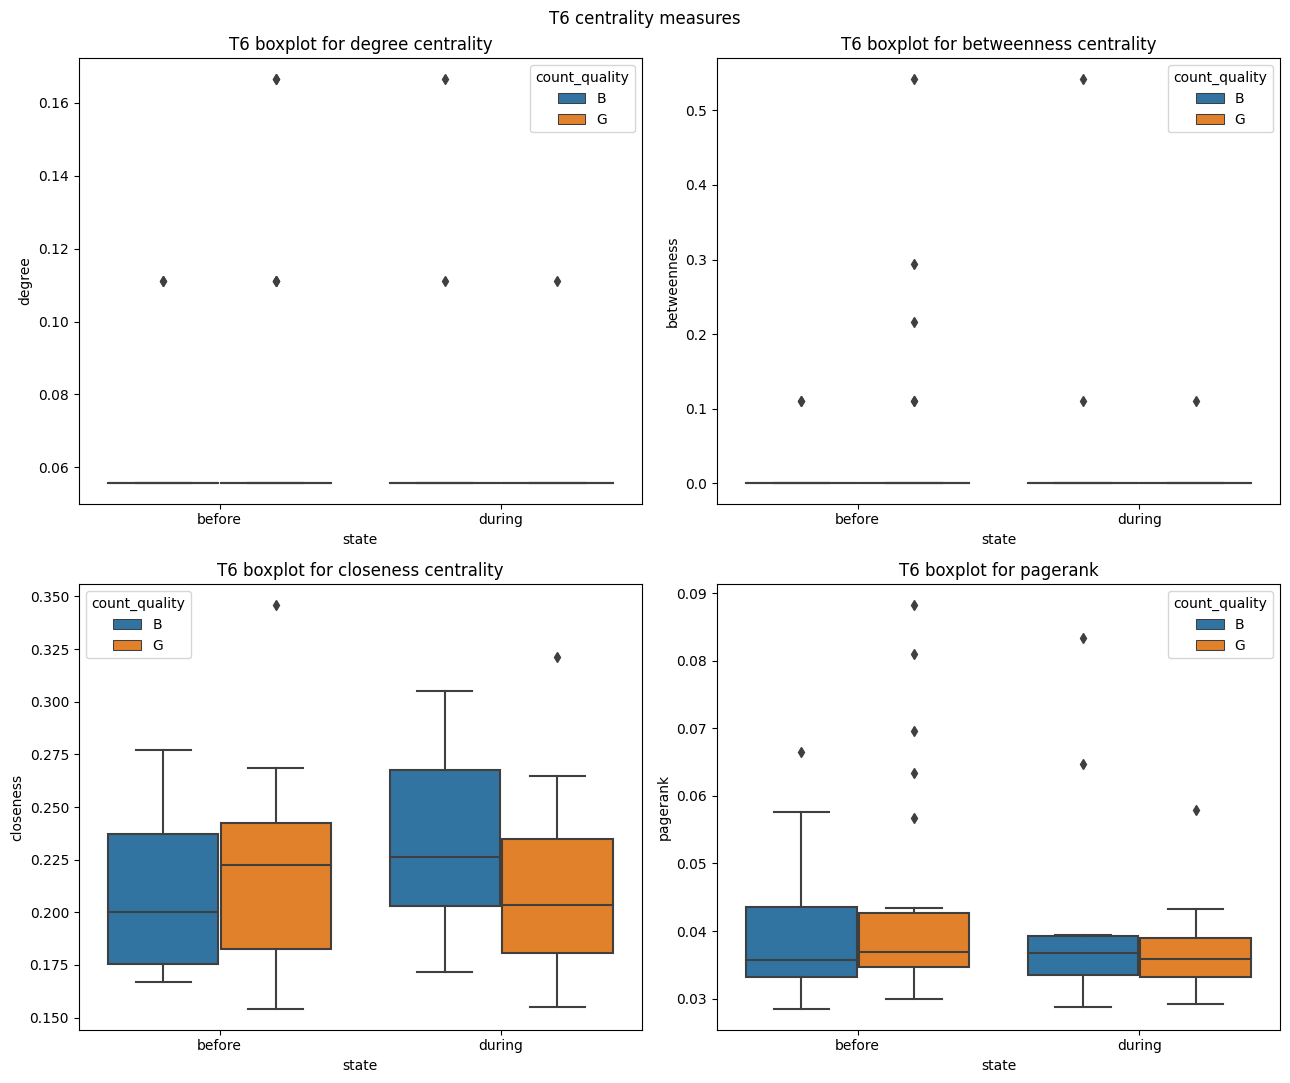

In [156]:
# Todas las gráficas de T6 para cada métrica diferente
sensor: str = 'T6'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

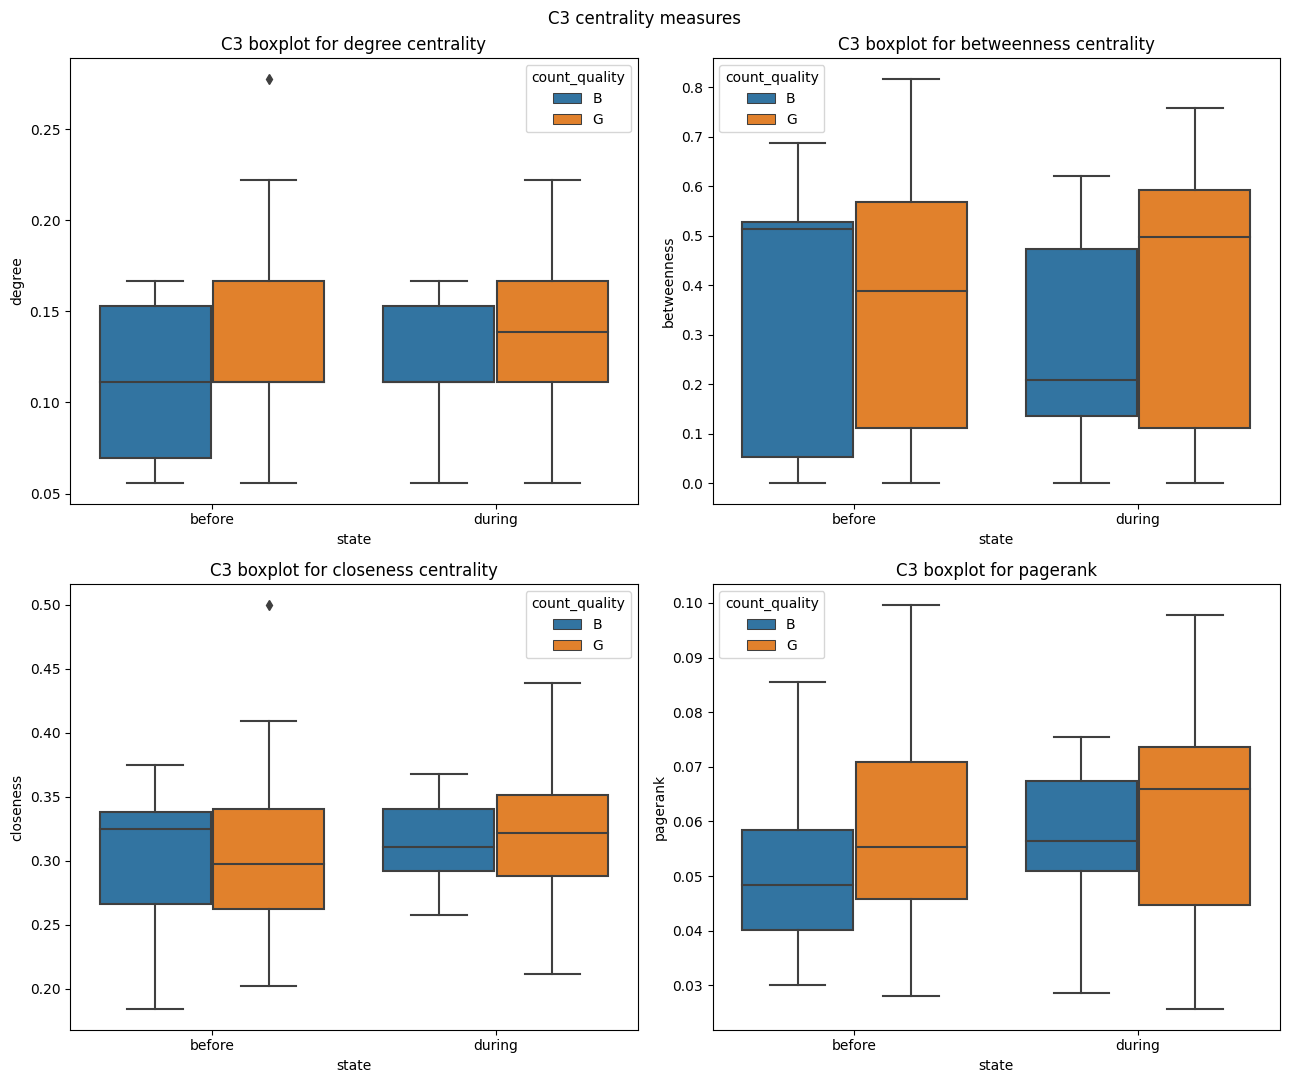

In [157]:
# Todas las gráficas de C3 para cada métrica diferente
sensor: str = 'C3'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

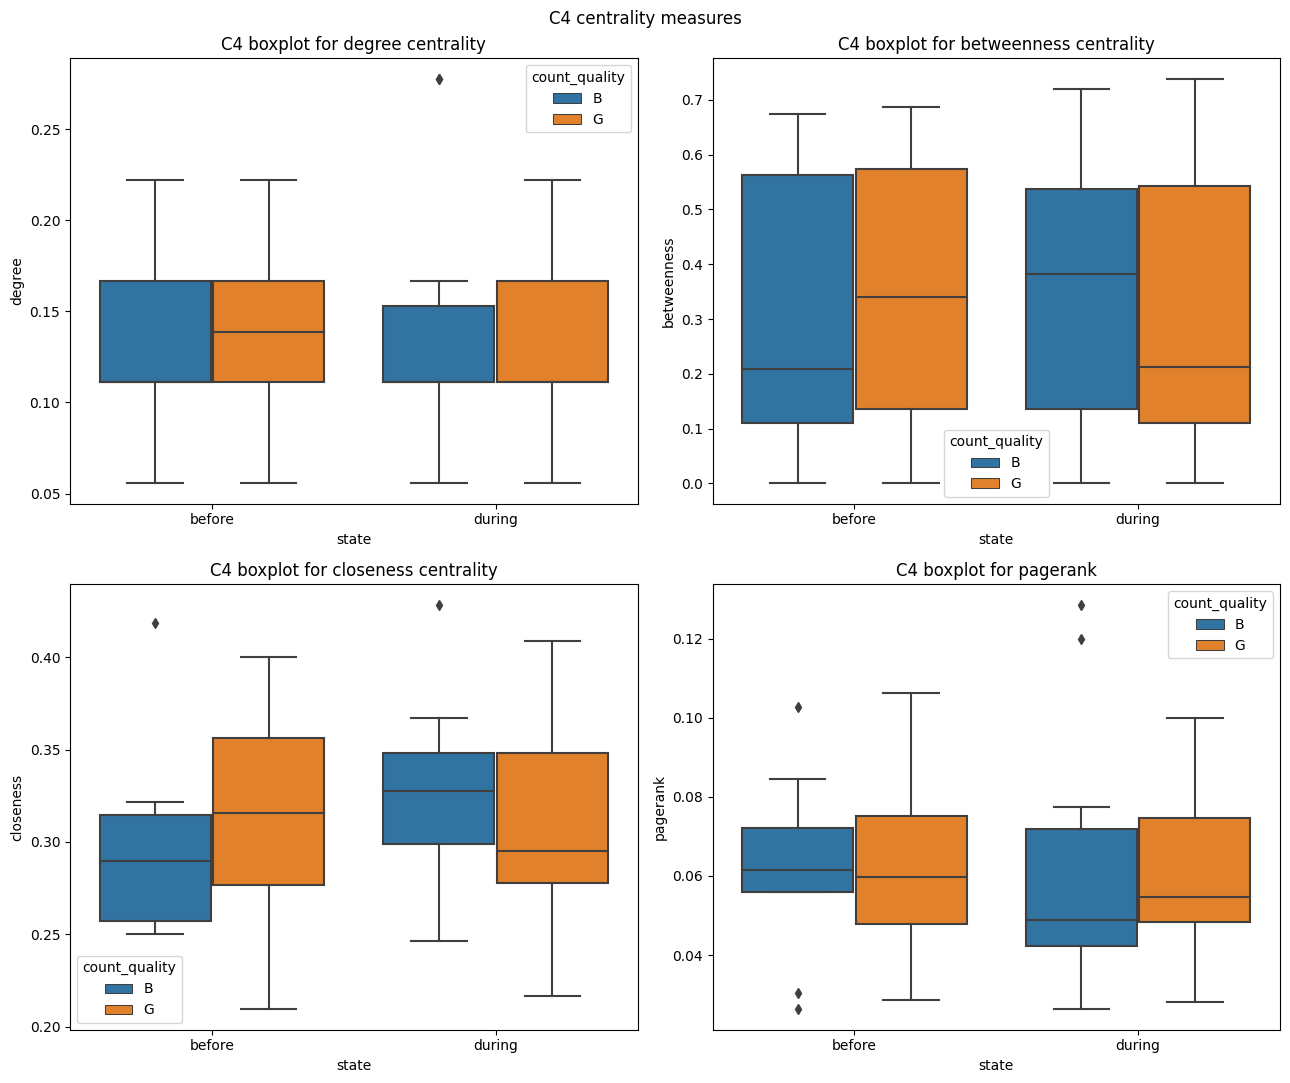

In [158]:
# Todas las gráficas de C4 para cada métrica diferente
sensor: str = 'C4'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

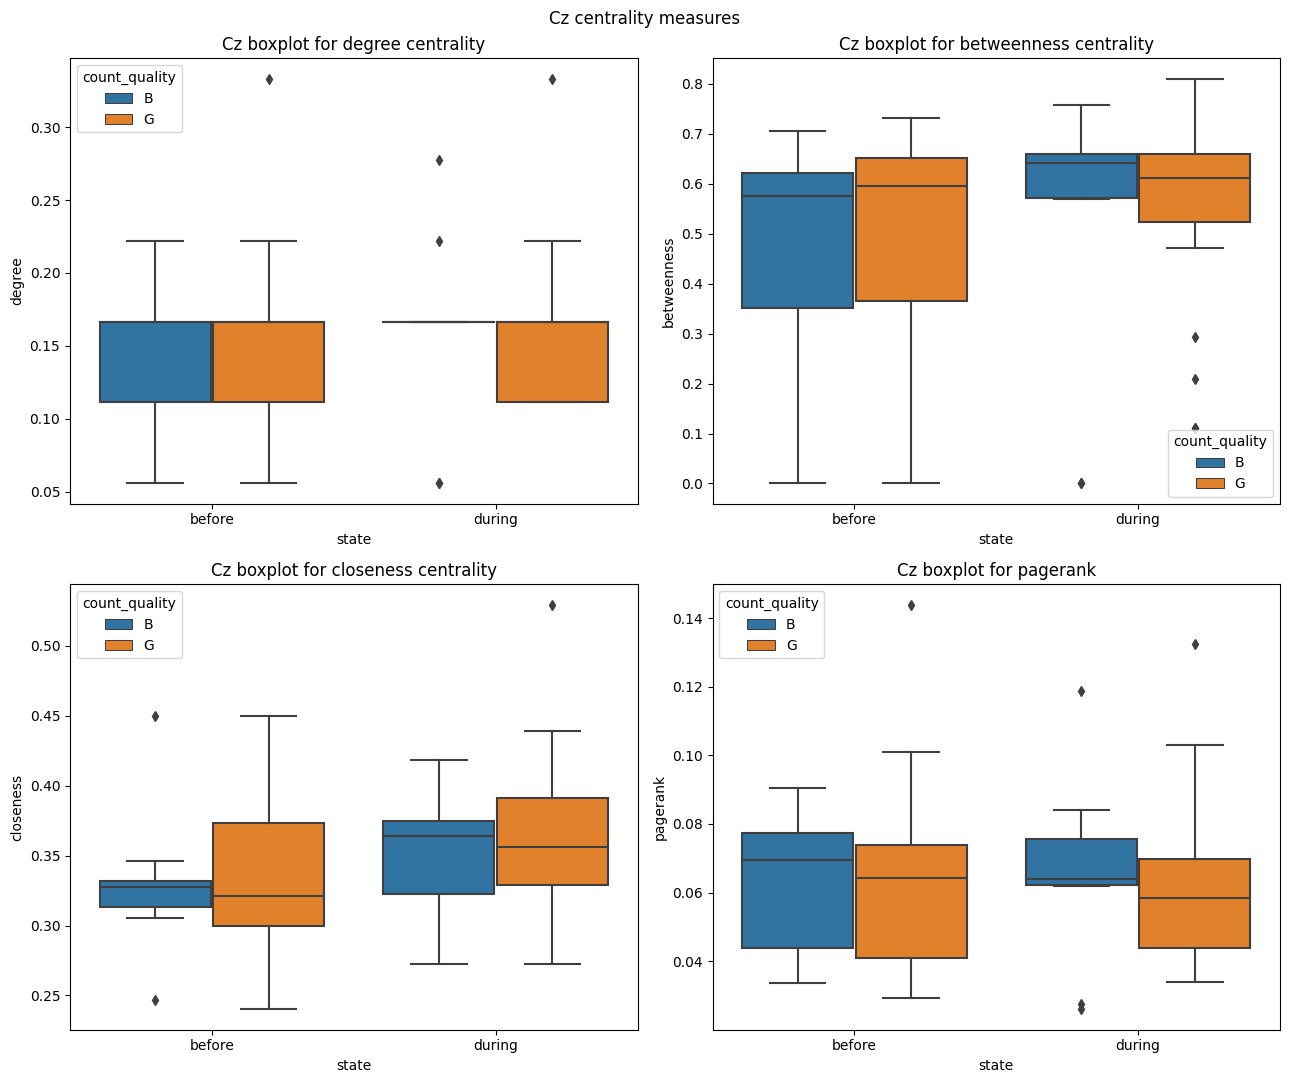

In [159]:
# Todas las gráficas de Cz para cada métrica diferente
sensor: str = 'Cz'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

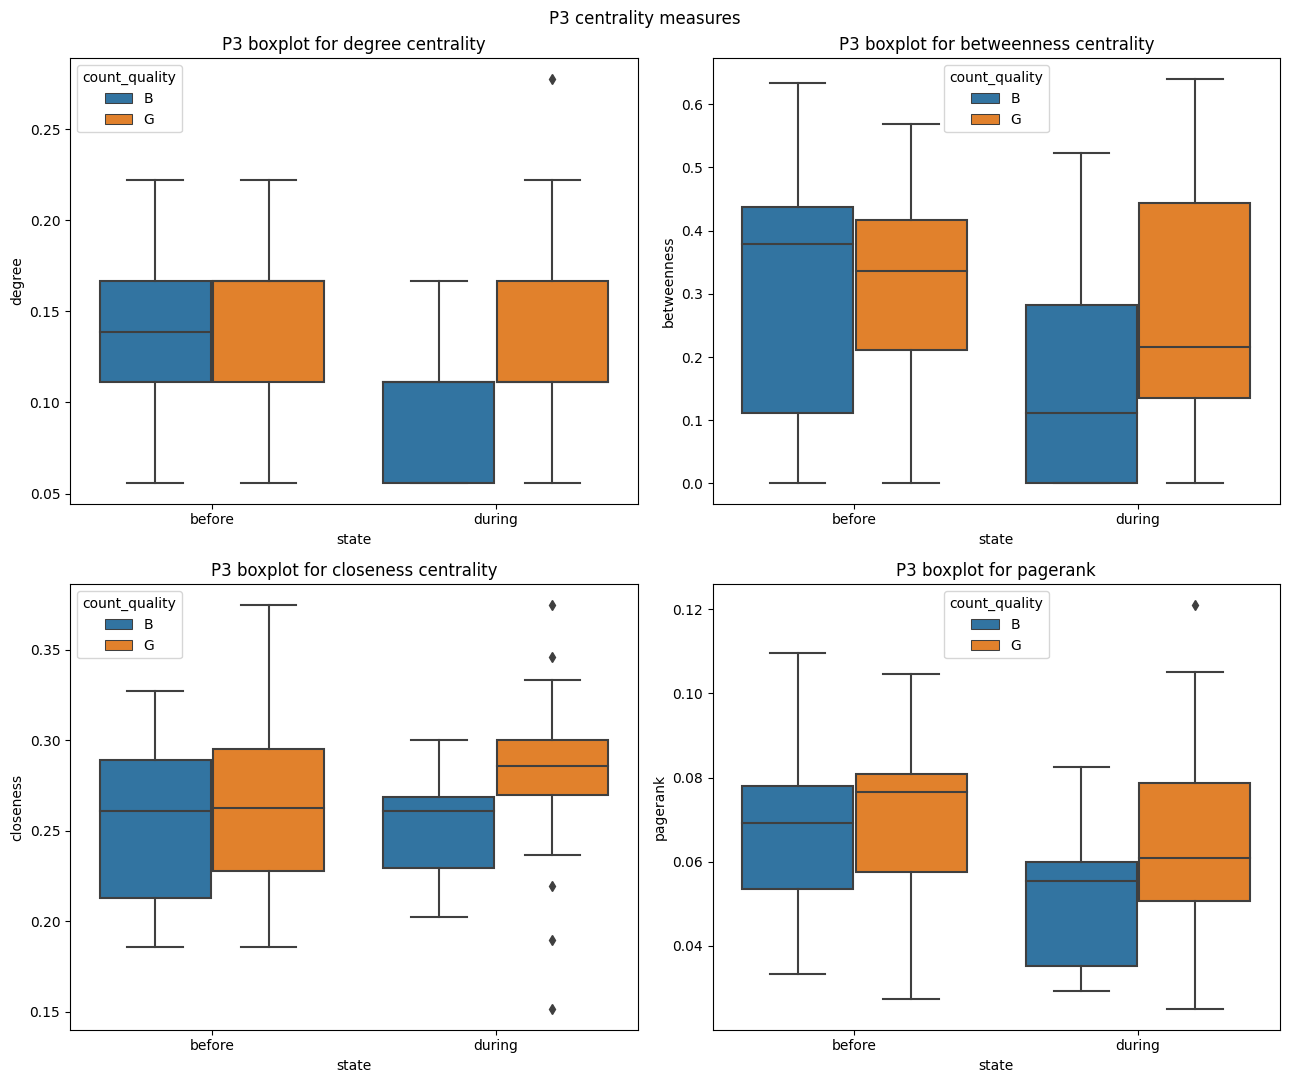

In [160]:
# Todas las gráficas de P3 para cada métrica diferente
sensor: str = 'P3'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

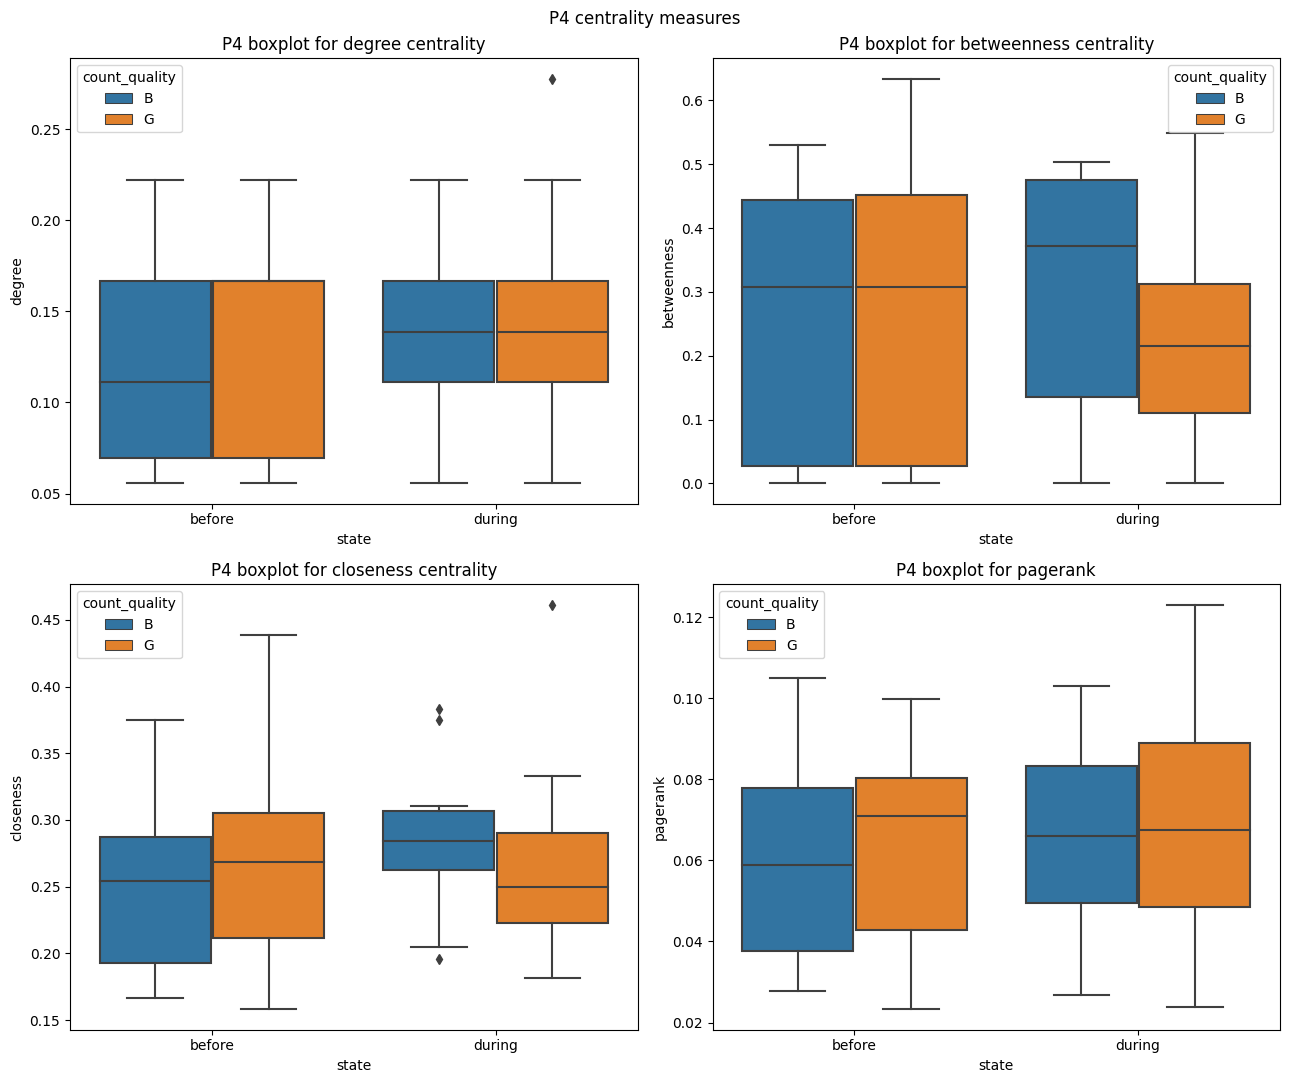

In [161]:
# Todas las gráficas de P4 para cada métrica diferente
sensor: str = 'P4'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

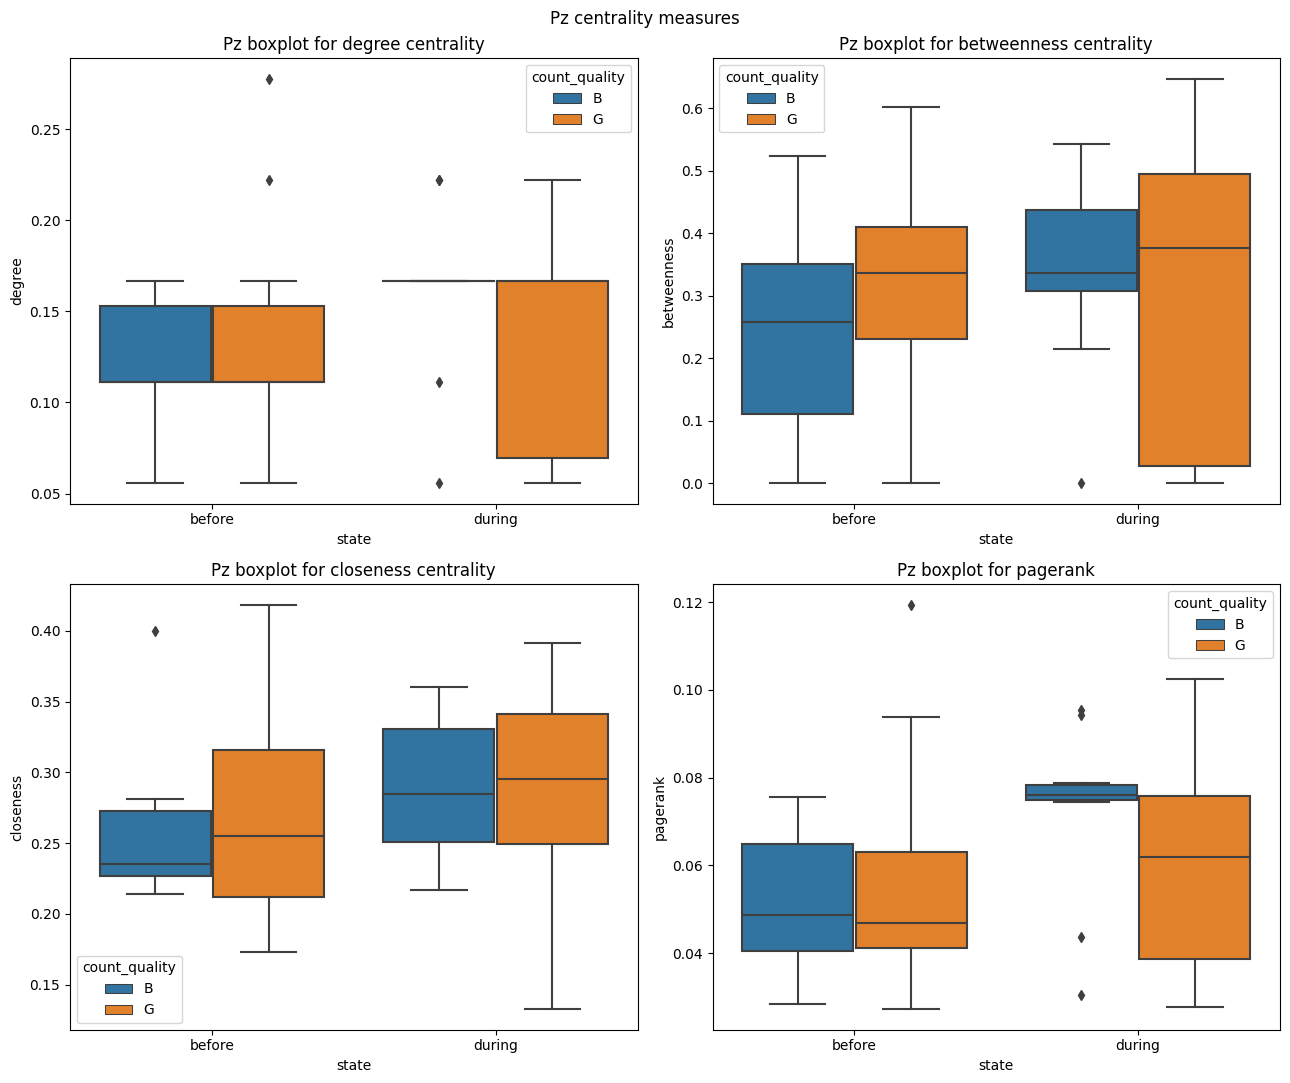

In [162]:
# Todas las gráficas de Pz para cada métrica diferente
sensor: str = 'Pz'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

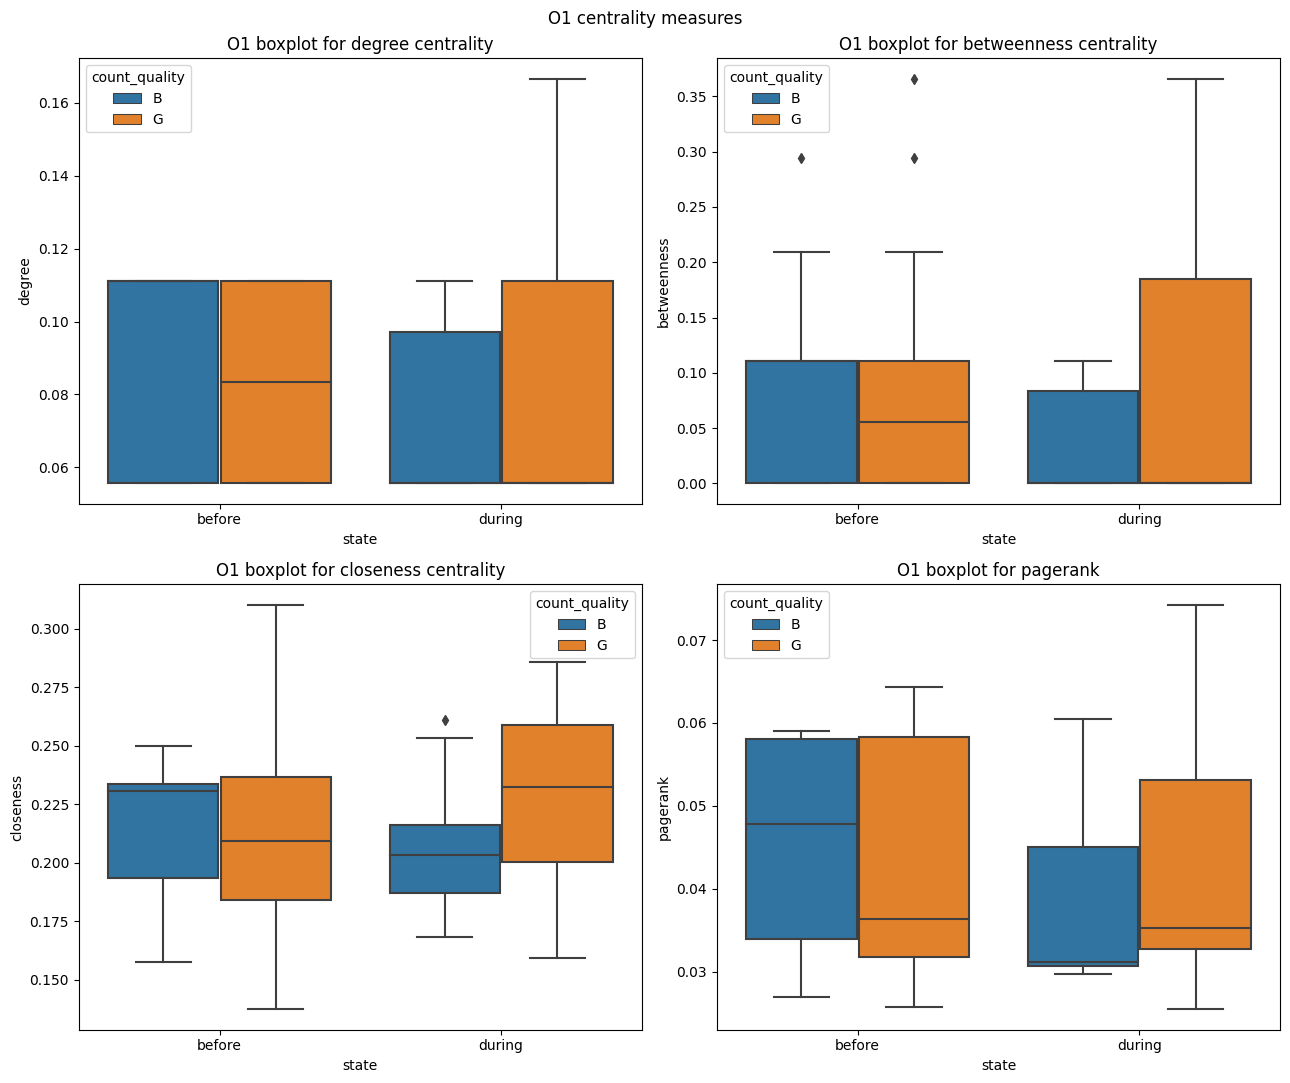

In [163]:
# Todas las gráficas de O1 para cada métrica diferente
sensor: str = 'O1'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

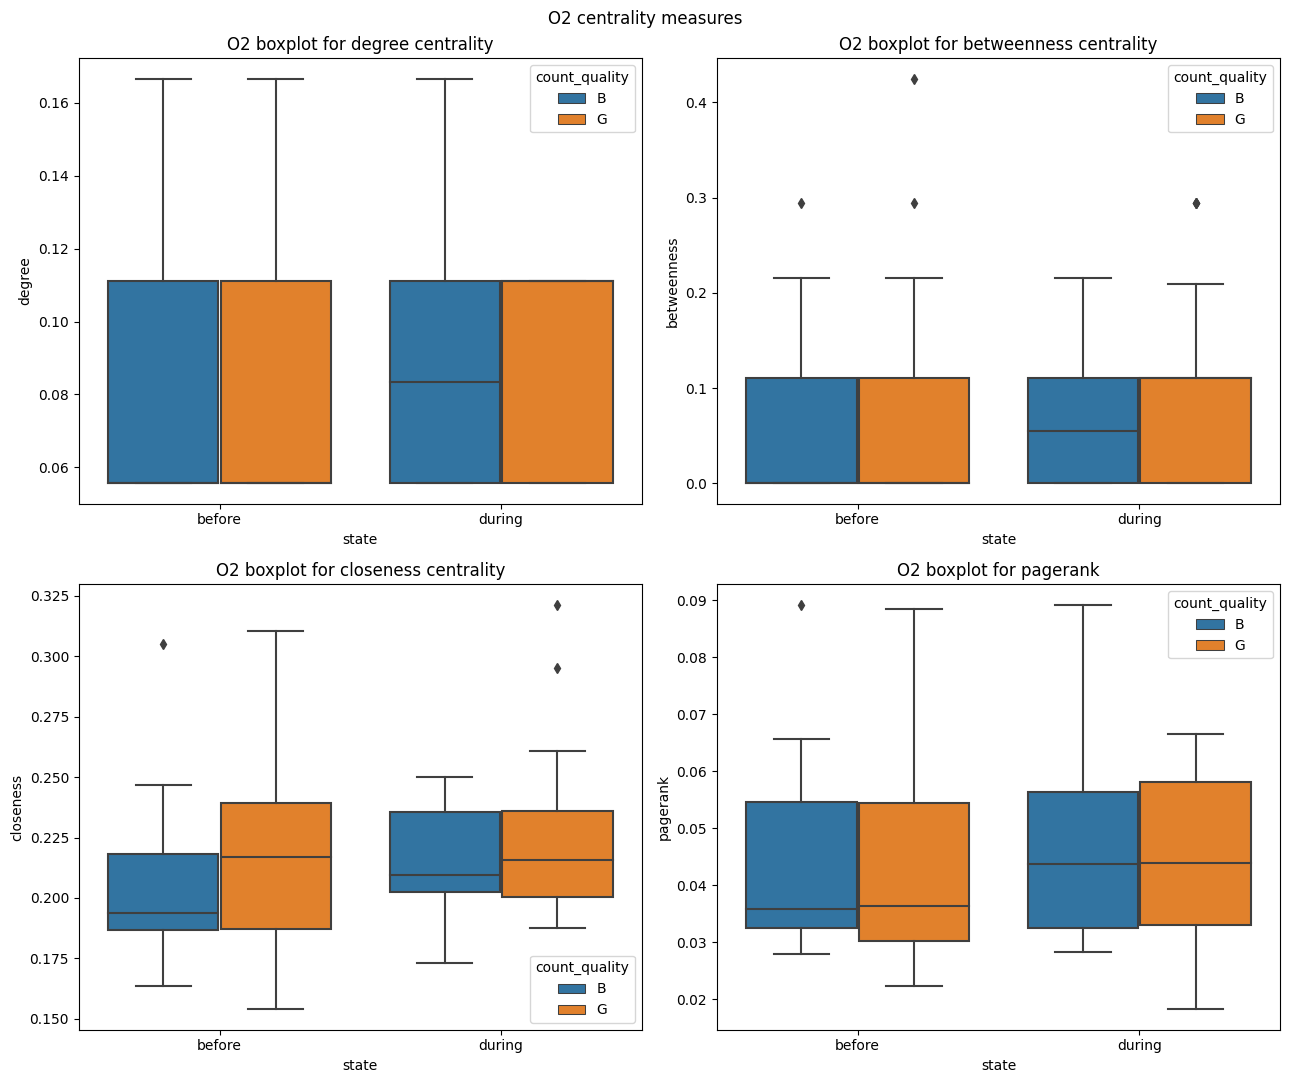

In [164]:
# Todas las gráficas de O2 para cada métrica diferente
sensor: str = 'O2'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

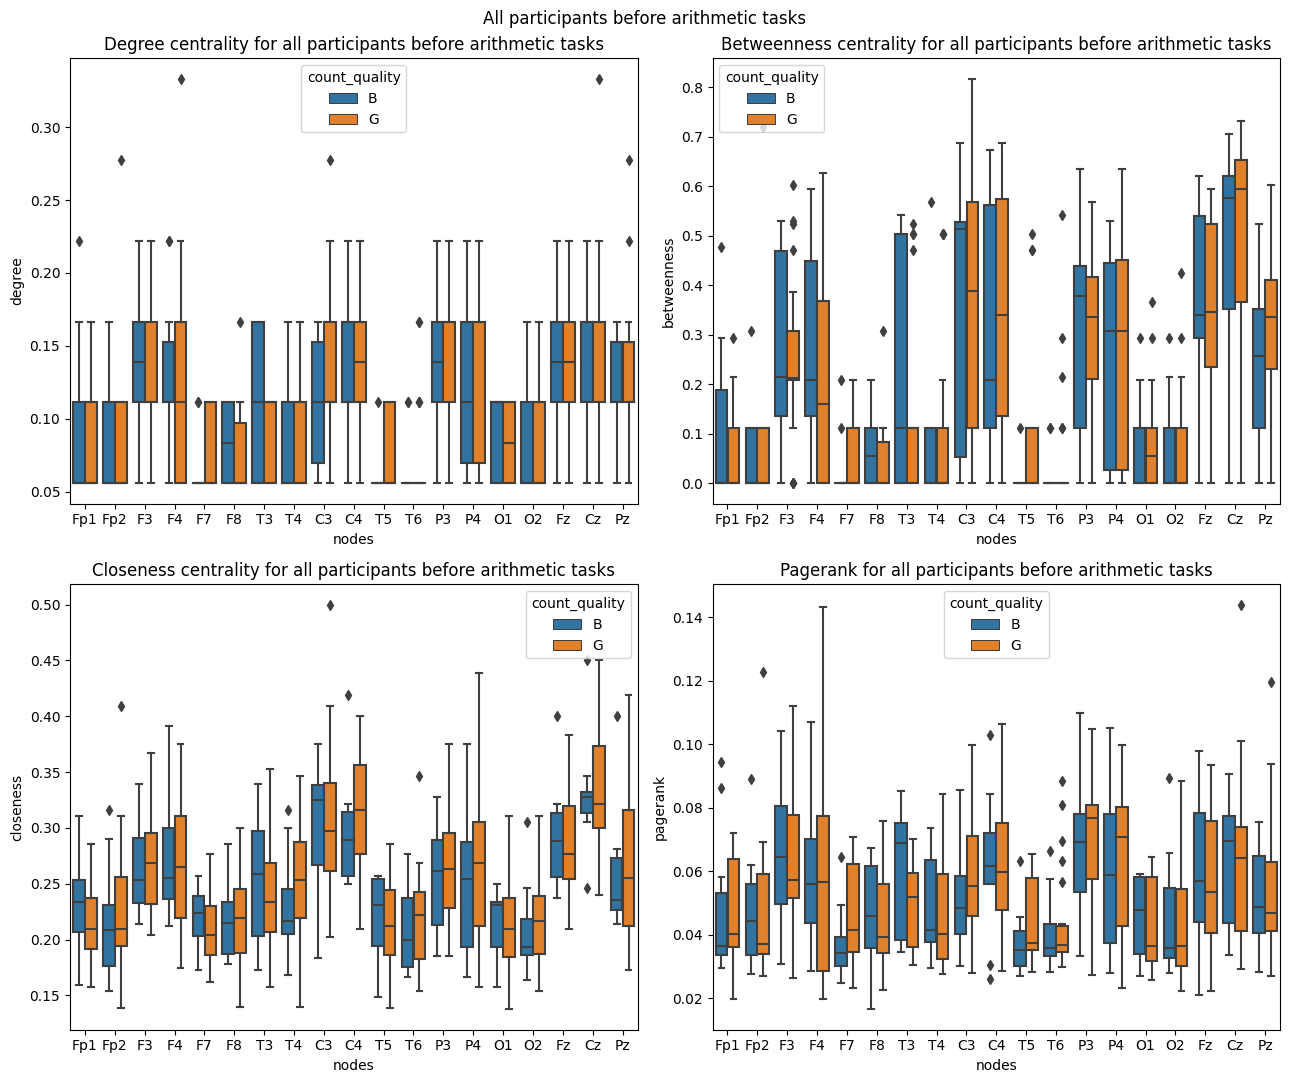

In [165]:
# Todos los nodos de los participantes antes

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('All participants before arithmetic tasks')

ax1.set_title('Degree centrality for all participants before arithmetic tasks')
sns.boxplot(
    df_before, x='nodes', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title('Betweenness centrality for all participants before arithmetic tasks')
sns.boxplot(
    df_before, x='nodes', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title('Closeness centrality for all participants before arithmetic tasks')
sns.boxplot(
    df_before, x='nodes', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title('Pagerank for all participants before arithmetic tasks')
sns.boxplot(
    df_before, x='nodes', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

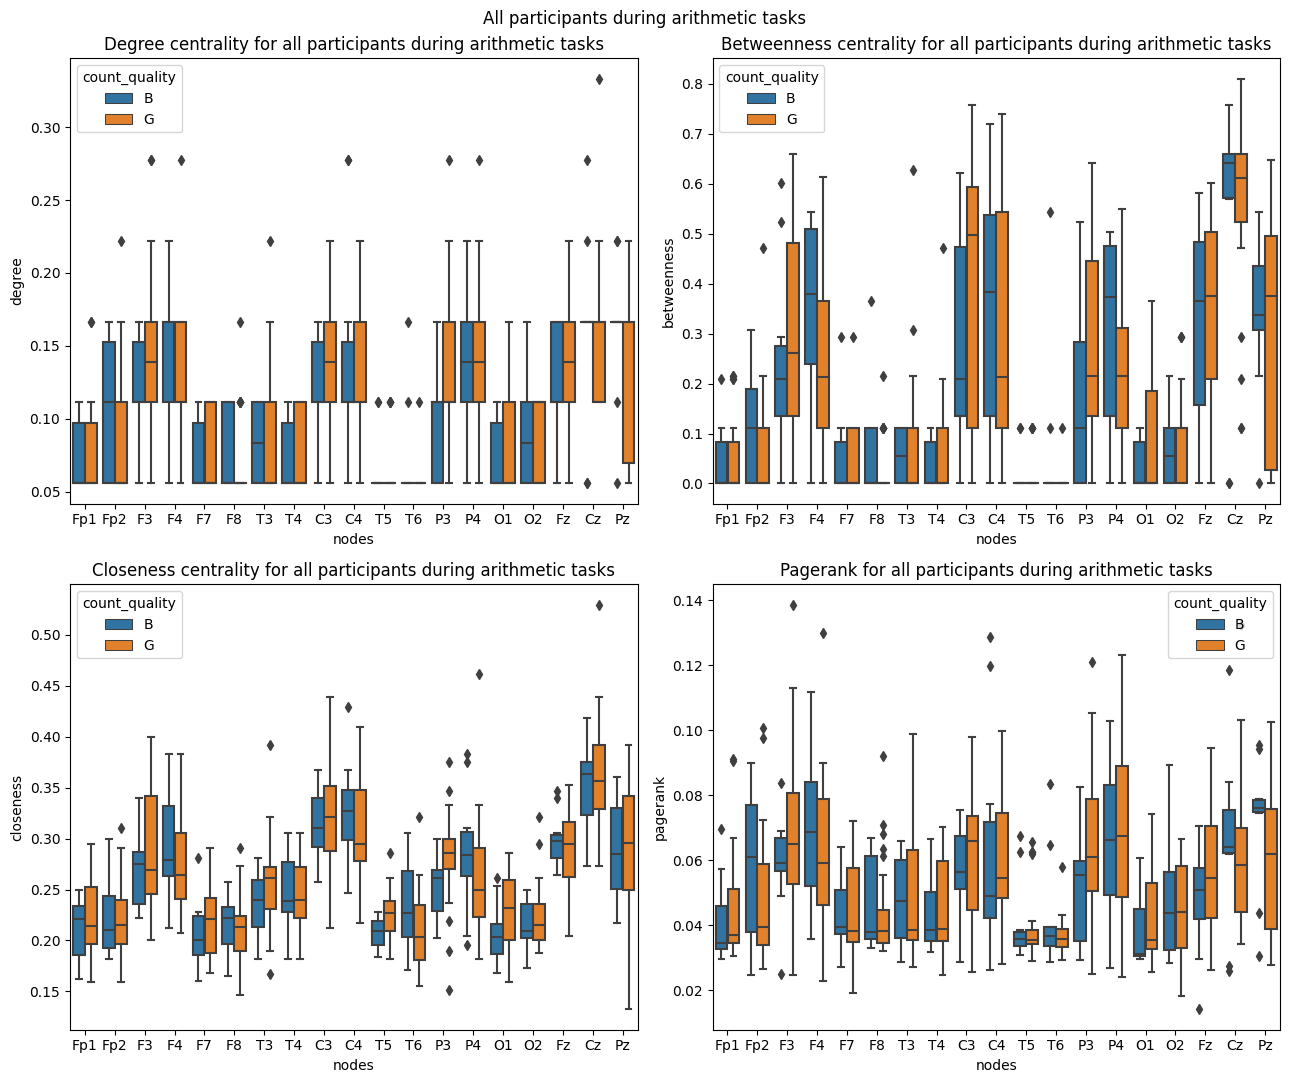

In [166]:
# Todos los nodos de los participantes durante

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('All participants during arithmetic tasks')

ax1.set_title('Degree centrality for all participants during arithmetic tasks')
sns.boxplot(
    df_during, x='nodes', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title('Betweenness centrality for all participants during arithmetic tasks')
sns.boxplot(
    df_during, x='nodes', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title('Closeness centrality for all participants during arithmetic tasks')
sns.boxplot(
    df_during, x='nodes', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title('Pagerank for all participants during arithmetic tasks')
sns.boxplot(
    df_during, x='nodes', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

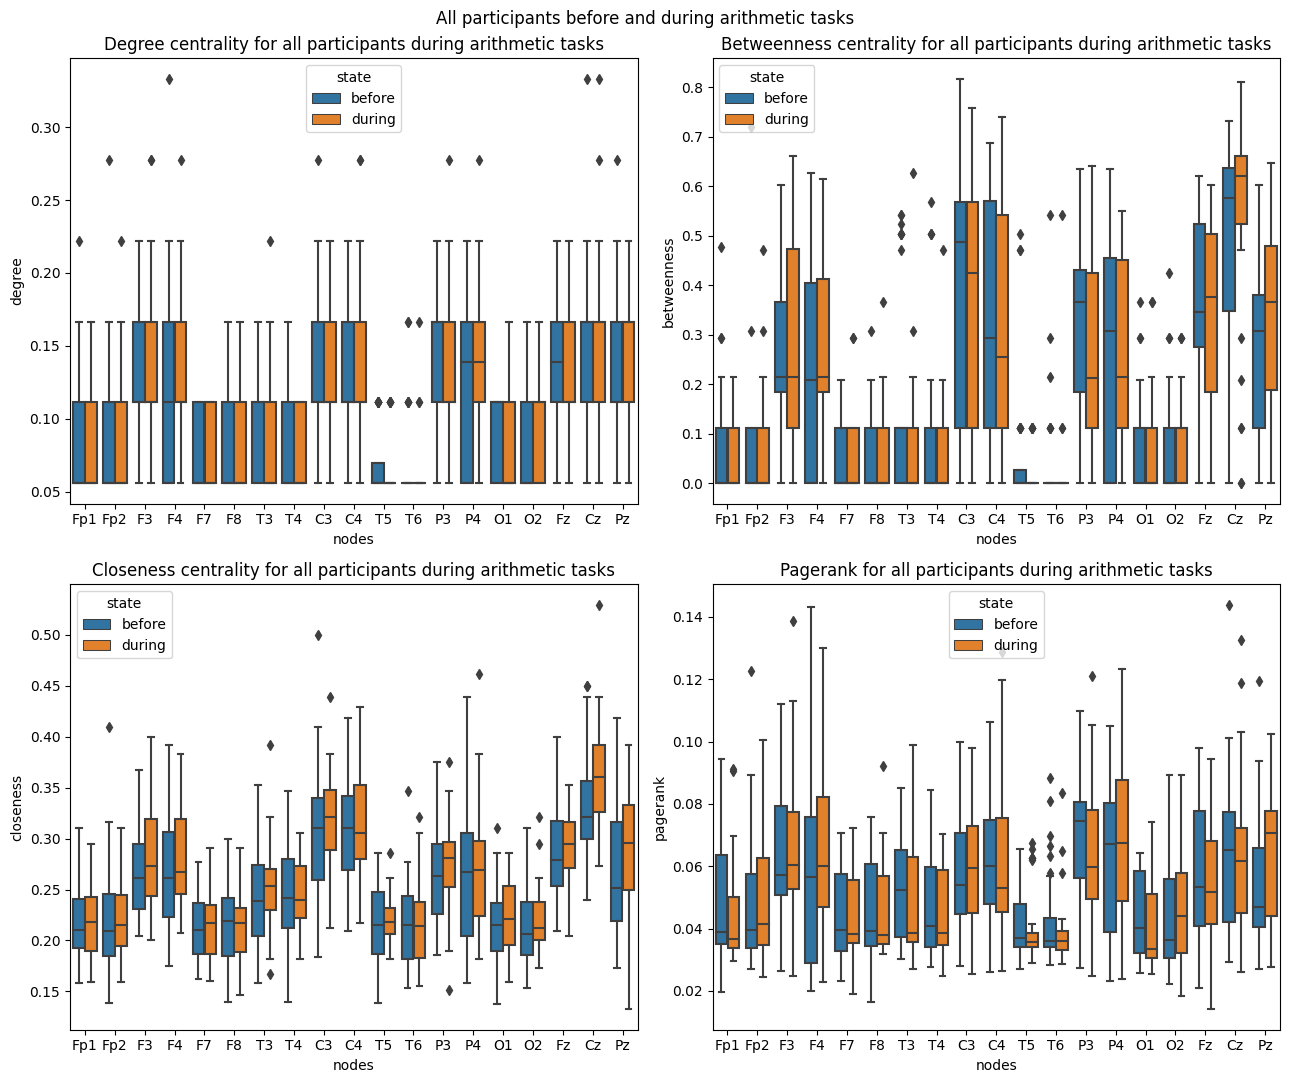

In [61]:
# Todos los nodos de los participantes durante

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('All participants before and during arithmetic tasks')

ax1.set_title('Degree centrality for all participants during arithmetic tasks')
sns.boxplot(
    df_result, x='nodes', y='degree', hue='state', ax=ax1
)

ax2.set_title('Betweenness centrality for all participants during arithmetic tasks')
sns.boxplot(
    df_result, x='nodes', y='betweenness', hue='state', ax=ax2
)

ax3.set_title('Closeness centrality for all participants during arithmetic tasks')
sns.boxplot(
    df_result, x='nodes', y='closeness', hue='state', ax=ax3
)

ax4.set_title('Pagerank for all participants during arithmetic tasks')
sns.boxplot(
    df_result, x='nodes', y='pagerank', hue='state', ax=ax4
)

plt.tight_layout()

# Promedio de todos los sujetos - Antes y durante

In [10]:
# Obtener el promedio de la matriz de distancias
n = 35 + 1

ave_before = np.zeros((19, 19))
ave_during = np.zeros((19, 19))

for i in range(n):
    subject = f'Subject{i:02}'
    csv_path1 = f'Archivos\\{subject}\\csv\\{subject}_1.csv'
    csv_path2 = f'Archivos\\{subject}\\csv\\{subject}_2.csv'

    ave_before += get_distances(csv_path1)
    ave_during += get_distances(csv_path2)

ave_before /= n
ave_during /= n

df_centrality_ave_bef = get_centrality_from_df(ave_before)
df_centrality_ave_dur = get_centrality_from_df(ave_during)

ave_before.to_csv('Archivos\\ave_distances_before.csv', sep=';', index=False)
ave_during.to_csv('Archivos\\ave_distances_during.csv', sep=';', index=False)

df_centrality_ave_bef.to_csv('Archivos\\ave_centrality_before.csv', sep=';', index=False)
df_centrality_ave_dur.to_csv('Archivos\\ave_centrality_during.csv', sep=';', index=False)

In [9]:
df_centrality_ave_bef = pd.read_csv('Archivos\\ave_centrality_before.csv', delimiter=';')
df_centrality_ave_bef['status'] = 'before'

df_centrality_ave_dur = pd.read_csv('Archivos\\ave_centrality_during.csv', delimiter=';')
df_centrality_ave_dur['status'] = 'during'

df_centrality_ave = pd.concat([df_centrality_ave_bef, df_centrality_ave_dur], ignore_index=True)

ave_before = pd.read_csv('Archivos\\ave_distances_before.csv', delimiter=';')
ave_before.index = CHANNELS

ave_during = pd.read_csv('Archivos\\ave_distances_during.csv', delimiter=';')
ave_during.index = CHANNELS

display(df_centrality_ave_bef.head(), df_centrality_ave_dur.head())
display(ave_before.head(), ave_during.head())

nodes    degree  betweenness  closeness  pagerank  status
0   Fp1  0.055556     0.000000   0.216867  0.034398  before
1   Fp2  0.055556     0.000000   0.216867  0.035419  before
2    F3  0.166667     0.215686   0.272727  0.082879  before
3    F4  0.166667     0.215686   0.272727  0.083671  before
4    F7  0.055556     0.000000   0.216867  0.034718  before

nodes    degree  betweenness  closeness  pagerank  status
0   Fp1  0.055556     0.000000   0.219512  0.035603  during
1   Fp2  0.055556     0.000000   0.219512  0.035193  during
2    F3  0.166667     0.215686   0.276923  0.084097  during
3    F4  0.166667     0.215686   0.276923  0.084132  during
4    F7  0.055556     0.000000   0.219512  0.034973  during

Fp1       Fp2        F3        F4        F7        F8        T3  \
Fp1  0.000000  0.967366  0.754793  0.895867  0.784633  1.082413  1.032186   
Fp2  0.967366  0.000000  0.895631  0.796026  1.086982  0.810338  1.193684   
F3   0.754793  0.895631  0.000000  0.647329  0.763891  0.960538  0.864771   
F4   0.895867  0.796026  0.647329  0.000000  0.987633  0.773837  1.033832   
F7   0.784633  1.086982  0.763891  0.987633  0.000000  1.153183  0.959522   

           T4        C3        C4        T5        T6        P3        P4  \
Fp1  1.182709  0.992638  1.052771  1.190535  1.361945  1.213462  1.275078   
Fp2  1.077322  1.062320  1.001765  1.334012  1.280024  1.258433  1.238752   
F3   1.038905  0.688403  0.805468  1.092216  1.268156  1.041076  1.108529   
F4   0.873228  0.809480  0.696215  1.216766  1.162620  1.103675  1.060819   
F7   1.223117  0.969052  1.089158  1.126198  1.384937  1.175359  1.259855   

           O1        O2        Fz        Cz        Pz  
Fp1  1.371657  1.392567  0.822460  0.990701  1.226724  
Fp2  1.397859  1.377037  0.815033  1.004146  1.236504  
F3   1.271590  1.288135  0.487559  0.698030  1.058847  
F4   1.298206  1.275379  0.486955  0.689071  1.065644  
F7   1.340329  1.370491  0.893355  1.016545  1.213705

Fp1       Fp2        F3        F4        F7        F8        T3  \
Fp1  0.000000  1.011771  0.856917  0.979207  0.883644  1.130806  1.074770   
Fp2  1.011771  0.000000  0.928938  0.844589  1.101674  0.872368  1.169350   
F3   0.856917  0.928938  0.000000  0.649104  0.837425  0.992772  0.835240   
F4   0.979207  0.844589  0.649104  0.000000  1.015559  0.850617  0.988483   
F7   0.883644  1.101674  0.837425  1.015559  0.000000  1.176140  0.977634   

           T4        C3        C4        T5        T6        P3        P4  \
Fp1  1.222024  1.041543  1.103740  1.190448  1.328500  1.212943  1.254206   
Fp2  1.093853  1.094092  1.041715  1.282581  1.249209  1.241410  1.218174   
F3   1.029954  0.686091  0.784422  1.055999  1.209461  0.989011  1.062619   
F4   0.885215  0.801758  0.688891  1.158650  1.112045  1.053421  1.022676   
F7   1.211040  0.988181  1.101315  1.143549  1.336502  1.174165  1.237023   

           O1        O2        Fz        Cz        Pz  
Fp1  1.336263  1.360402  0.916221  1.047779  1.233141  
Fp2  1.345627  1.338101  0.885741  1.037516  1.237020  
F3   1.208749  1.240850  0.516400  0.683593  1.027873  
F4   1.236415  1.228701  0.517382  0.682510  1.034001  
F7   1.319433  1.342124  0.943079  1.035955  1.208312

In [10]:
mst_ave_before = get_mst_from_df(ave_before)
mst_ave_during = get_mst_from_df(ave_during)

for i, node in enumerate(CHANNELS):
    mst_ave_before.nodes[node]['degree'] = round(df_centrality_ave_bef['degree'][i], 2)
    mst_ave_before.nodes[node]['betweenness'] = round(df_centrality_ave_bef['betweenness'][i], 2)
    mst_ave_before.nodes[node]['closeness'] = round(df_centrality_ave_bef['closeness'][i], 2)
    mst_ave_before.nodes[node]['pagerank'] = round(df_centrality_ave_bef['pagerank'][i], 2)

    mst_ave_during.nodes[node]['degree'] = round(df_centrality_ave_dur['degree'][i], 2)
    mst_ave_during.nodes[node]['betweenness'] = round(df_centrality_ave_dur['betweenness'][i], 2)
    mst_ave_during.nodes[node]['closeness'] = round(df_centrality_ave_dur['closeness'][i], 2)
    mst_ave_during.nodes[node]['pagerank'] = round(df_centrality_ave_dur['pagerank'][i], 2)

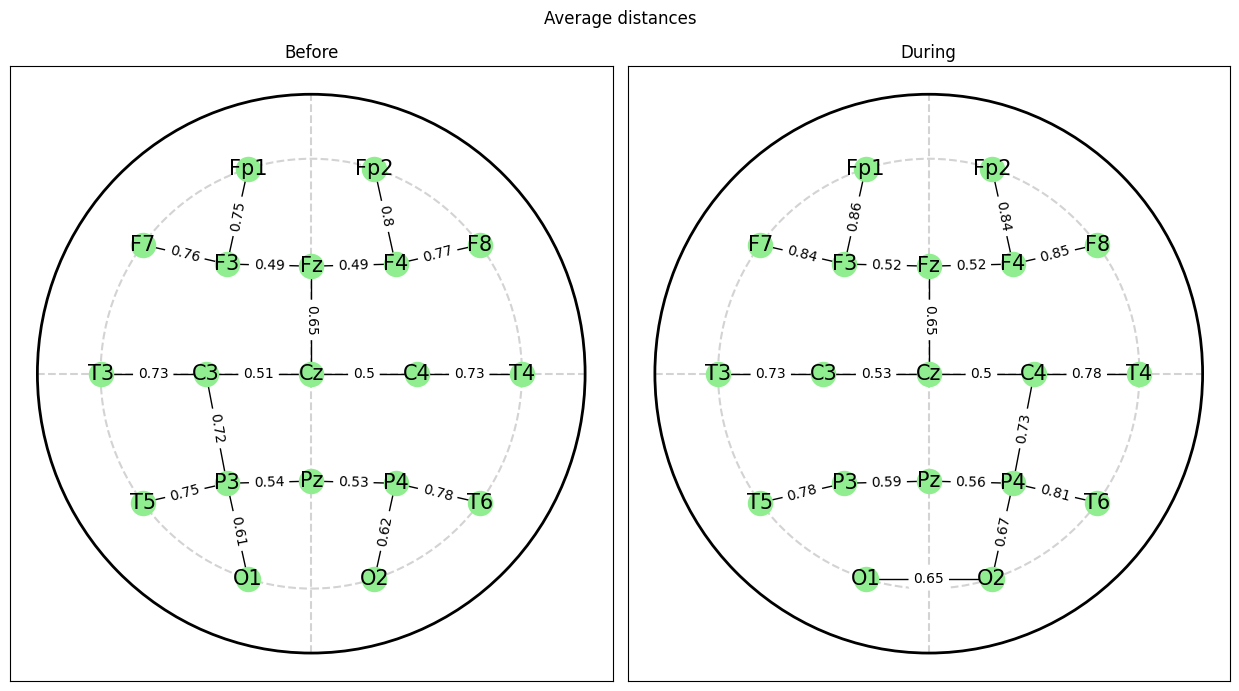

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 7))
fig.suptitle('Average distances')

for ax in (ax1, ax2):
    ax.add_patch(Circle((0, 0), radius=1, color='lightgray', fill=False, linestyle='--', linewidth=1.5))
    ax.add_patch(Circle((0, 0), radius=1.3, color='black', fill=False, linewidth=2))

    # Agregar segmentos
    ax.plot([0, 0], [-1.3, 1.3], linestyle='--', color='lightgray', linewidth=1.5, zorder=0)
    ax.plot([-1.3, 1.3], [0, 0], linestyle='--', color='lightgray', linewidth=1.5, zorder=0)

ax1.set_title('Before')
nx.draw_networkx(
    mst_ave_before,
    pos,
    ax = ax1,
    font_size=15,
    node_color='lightgreen'
)

nx.draw_networkx_edge_labels(
    mst_ave_before,
    pos,
    {pair: round(weight, 2) for pair, weight in nx.get_edge_attributes(mst_ave_before, 'weight').items()},
    ax=ax1
)

ax2.set_title('During')
nx.draw_networkx(
    mst_ave_during,
    pos,
    ax=ax2,
    font_size=15,
    node_color='lightgreen'
)

nx.draw_networkx_edge_labels(
    mst_ave_during,
    pos,
    {pair: round(weight, 2) for pair, weight in nx.get_edge_attributes(mst_ave_during, 'weight').items()},
    ax=ax2
)

plt.tight_layout()
plt.show()

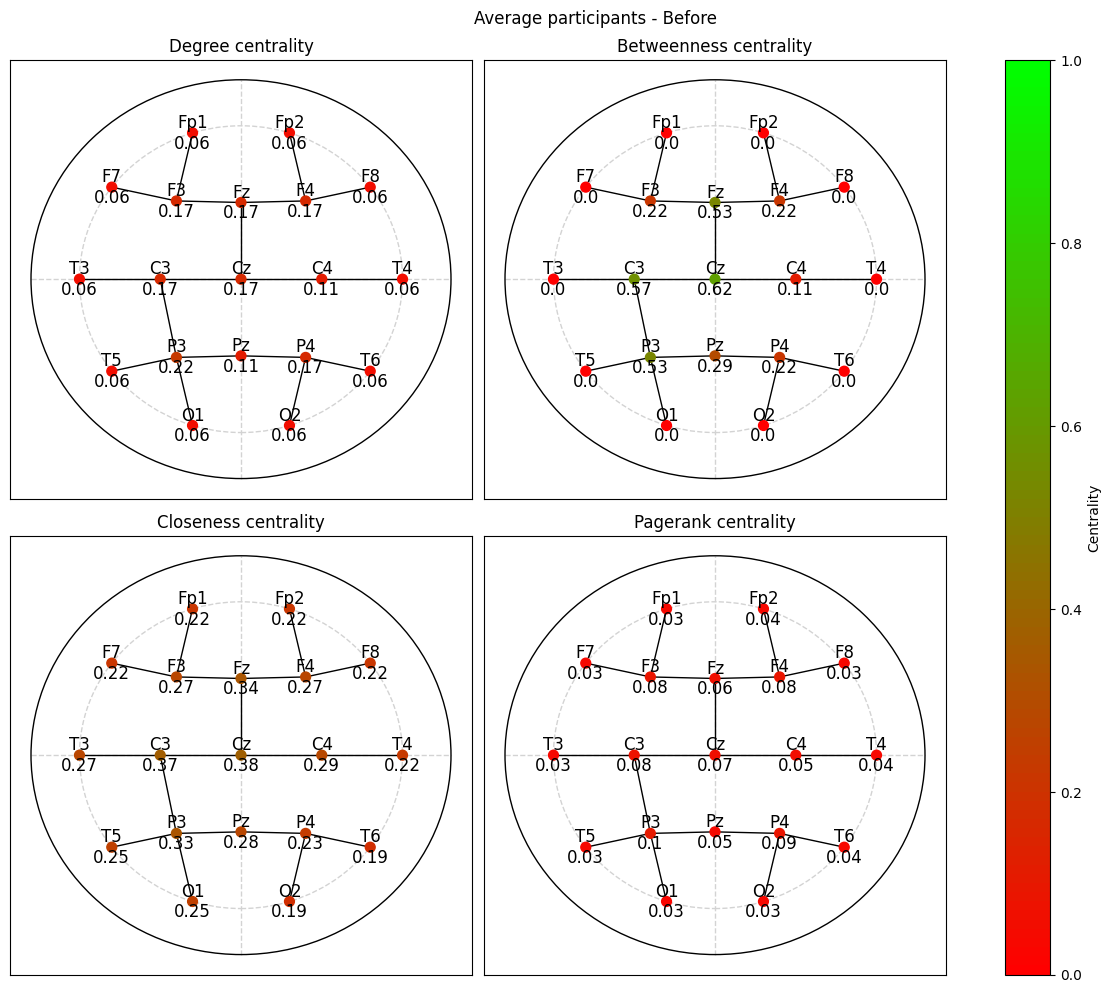

In [12]:
# Promedio de todos los participantes - antes

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Define un mapa de colores personalizado para el degradado (rojo a verde)
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#FF0000', '#00FF00'], N=100)

# Función para asignar un color en función de la medida de centralidad
def get_node_color(i: int, measure: str) -> tuple:
    measure_centrality = df_centrality_ave_bef.get(measure)
    return cmap(measure_centrality[i])

def plot_measure(G, measure, ax) -> None:
    # En caso de querer ver los nodos y la medida de centralidad
    temp_labels = {node: f'{node}\n{temp_centrality[measure]}' for node, temp_centrality in G.nodes(data=True)}

    ax.add_patch(Circle((0, 0), radius=1.3, color='black', fill=False, linewidth=1))
    ax.add_patch(Circle((0, 0), radius=1, color='lightgray', fill=False, linestyle='--', linewidth=1))

    # Agregar segmentos
    ax.plot([0, 0], [-1.3, 1.3], linestyle='--', color='lightgray', linewidth=1, zorder=0)
    ax.plot([-1.3, 1.3], [0, 0], linestyle='--', color='lightgray', linewidth=1, zorder=0)

    nx.draw_networkx(
        G,
        pos,
        node_size=50,
        with_labels=True,
        ax=ax,
        node_color=[get_node_color(i, measure) for i, _ in enumerate(G.nodes())],
        labels=temp_labels
    )

    ax.set_title(f'{measure.title()} centrality')

# Degree
plot_measure(mst_ave_before, 'degree', ax1)

# Betweenness
plot_measure(mst_ave_before, 'betweenness', ax2)

# Closeness
plot_measure(mst_ave_before, 'closeness', ax3)

# Pagerank
plot_measure(mst_ave_before, 'pagerank', ax4)

fig.suptitle('Average participants - Before')

plt.tight_layout()

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
plt.colorbar(sm, label='Centrality', ax=(ax1, ax2, ax3, ax4))

plt.show()

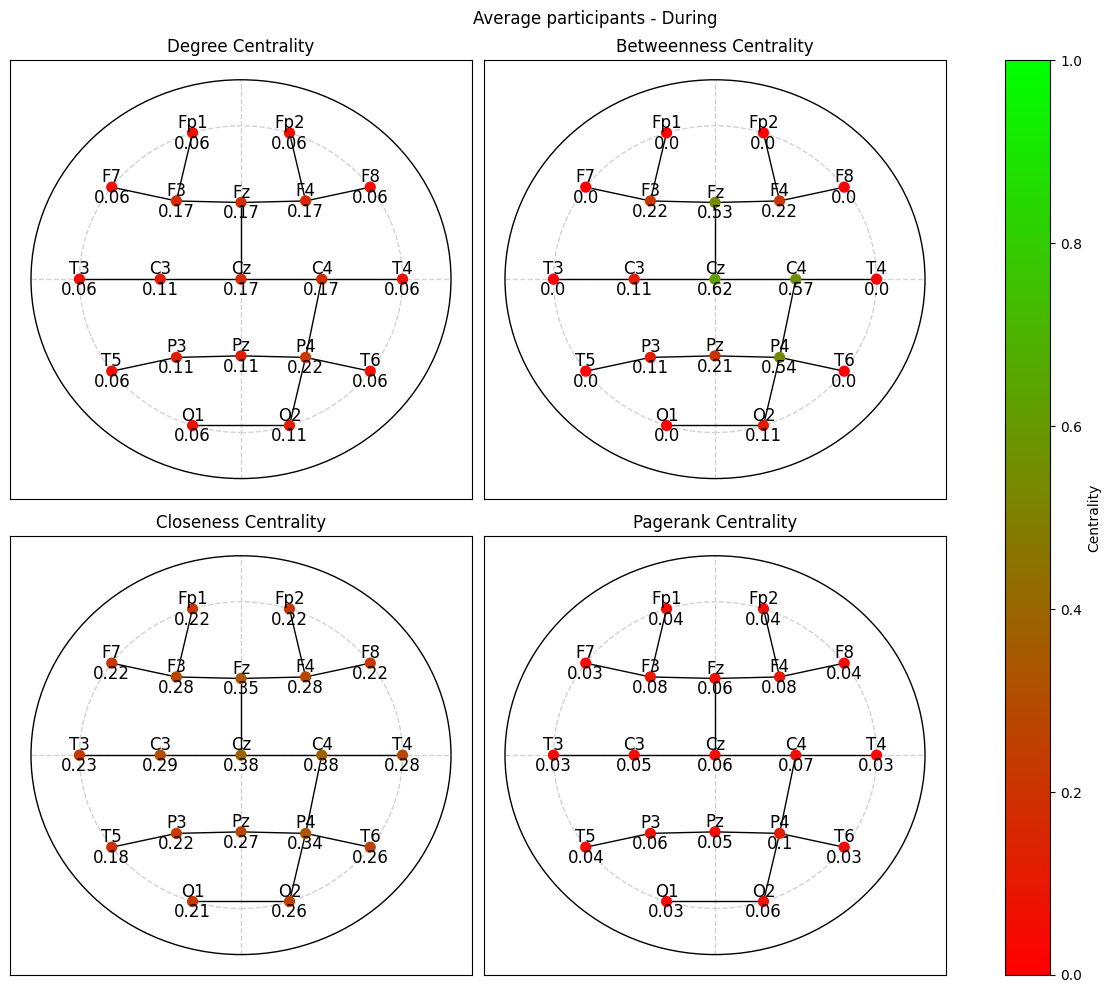

In [13]:
# Promedio de todos los participantes - durante

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Define un mapa de colores personalizado para el degradado (rojo a verde)
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#FF0000', '#00FF00'], N=100)

# Función para asignar un color en función de la medida de centralidad
def get_node_color(i: int, measure: str) -> tuple:
    measure_centrality = df_centrality_ave_dur.get(measure)
    return cmap(measure_centrality[i])

def plot_measure(G, measure, ax) -> None:
    # En caso de querer ver los nodos y la medida de centralidad
    temp_labels = {node: f'{node}\n{temp_centrality[measure]}' for node, temp_centrality in G.nodes(data=True)}

    ax.add_patch(Circle((0, 0), radius=1.3, color='black', fill=False, linewidth=1))
    ax.add_patch(Circle((0, 0), radius=1, color='lightgray', fill=False, linestyle='--', linewidth=1))

    # Agregar segmentos
    ax.plot([0, 0], [-1.3, 1.3], linestyle='--', color='lightgray', linewidth=1, zorder=0)
    ax.plot([-1.3, 1.3], [0, 0], linestyle='--', color='lightgray', linewidth=1, zorder=0)

    nx.draw_networkx(
        G,
        pos,
        node_size=50,
        with_labels=True,
        ax=ax,
        node_color=[get_node_color(i, measure) for i, _ in enumerate(G.nodes())],
        labels=temp_labels
    )
    
    ax.set_title(f'{measure.title()} Centrality')

# Degree
plot_measure(mst_ave_during, 'degree', ax1)

# Betweenness
plot_measure(mst_ave_during, 'betweenness', ax2)

# Closeness
plot_measure(mst_ave_during, 'closeness', ax3)

# Pagerank
plot_measure(mst_ave_during, 'pagerank', ax4)

fig.suptitle('Average participants - During')

plt.tight_layout()

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
plt.colorbar(sm, label='Centrality', ax=(ax1, ax2, ax3, ax4))

plt.show()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

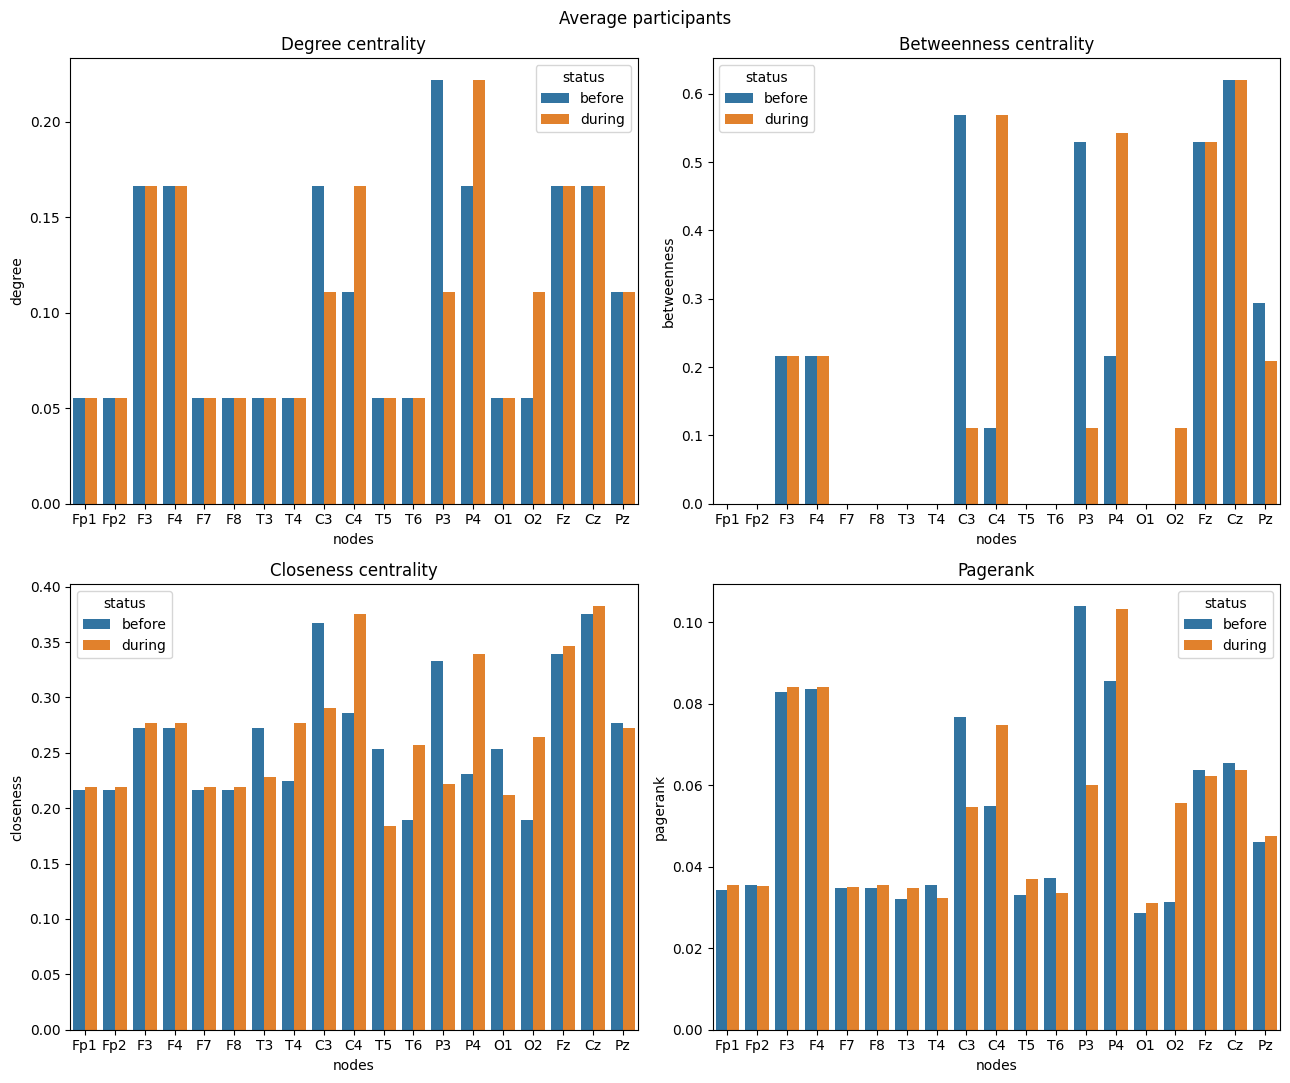

In [31]:
# Todos los nodos de los participantes durante

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('Average participants')

ax1.set_title('Degree centrality')
sns.barplot(
    df_centrality_ave, x='nodes', y='degree', hue='status', ax=ax1
)

ax2.set_title('Betweenness centrality')
sns.barplot(
    df_centrality_ave, x='nodes', y='betweenness', hue='status', ax=ax2
)

ax3.set_title('Closeness centrality')
sns.barplot(
    df_centrality_ave, x='nodes', y='closeness', hue='status', ax=ax3
)

ax4.set_title('Pagerank')
sns.barplot(
    df_centrality_ave, x='nodes', y='pagerank', hue='status', ax=ax4
)

plt.tight_layout()

## Boxplots para las distancias con mayor diferencia en los grafos de promedio

En base al gráfico obtenido, las distancias que más tuvieron diferencias fueron

- Fp1 - F3  
Antes: 0.75  
Durante: 0.86  

- F7 - F3  
Antes: 0.76  
Durante: 0.84  

- F4 - F8:  
Antes: 0.77  
Durante: 0.85

In [131]:
N = 36

# [Datos_antes, Datos_durante]
fp1_to_f3 = np.zeros((2, N), dtype=float)
f7_to_f3 = np.zeros((2, N), dtype=float)
f4_to_f8 = np.zeros((2, N), dtype=float)

for i in range(N):
    subject = f'Subject{i:02}'
    csv_path1 = f'Archivos\\{subject}\\csv\\{subject}_1.csv'
    csv_path2 = f'Archivos\\{subject}\\csv\\{subject}_2.csv'

    temp_before = get_distances(csv_path1)
    temp_during = get_distances(csv_path2)

    fp1_to_f3[0][i], fp1_to_f3[1][i] = temp_before['Fp1']['F3'], temp_during['Fp1']['F3']
    f7_to_f3[0][i], f7_to_f3[1][i] = temp_before['F7']['F3'], temp_during['F7']['F3']
    f4_to_f8[0][i], f4_to_f8[1][i] = temp_before['F4']['F8'], temp_during['F4']['F8']

In [135]:
df_fp1_to_f3_bef = pd.DataFrame({
    'pair': ['Fp1 - F3']*N, 'status': ['before']*N, 'distance': fp1_to_f3[0]
})

df_fp1_to_f3_dur = pd.DataFrame({
    'pair': ['Fp1 - F3']*N, 'status': ['during']*N, 'distance': fp1_to_f3[1]
})

df_fp1_to_f3 = pd.concat([df_fp1_to_f3_bef, df_fp1_to_f3_dur], ignore_index=True)


df_f7_to_f3_bef = pd.DataFrame({
    'pair': ['F7 - F3']*N, 'status': ['before']*N, 'distance': f7_to_f3[0]
})

df_f7_to_f3_dur = pd.DataFrame({
    'pair': ['F7 - F3']*N, 'status': ['during']*N, 'distance': f7_to_f3[1]
})

df_f7_to_f3 = pd.concat([df_f7_to_f3_bef, df_f7_to_f3_dur], ignore_index=True)


df_f4_to_f8_bef = pd.DataFrame({
    'pair': ['F4 - F8']*N, 'status': ['before']*N, 'distance': f4_to_f8[0]
})

df_f4_to_f8_dur = pd.DataFrame({
    'pair': ['F4 - F8']*N, 'status': ['during']*N, 'distance': f4_to_f8[1]
})

df_f4_to_f8 = pd.concat([df_f4_to_f8_bef, df_f4_to_f8_dur], ignore_index=True)

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


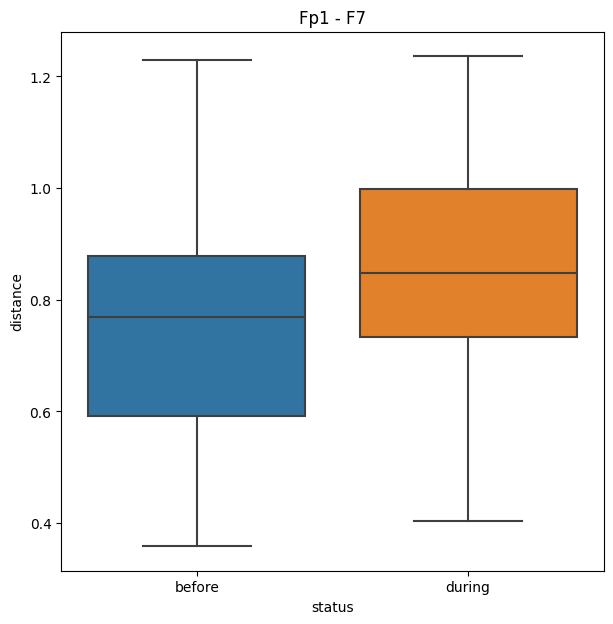

In [138]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_title('Fp1 - F7')

sns.boxplot(
    df_fp1_to_f3, x='status', y='distance', ax=ax
)

plt.show()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


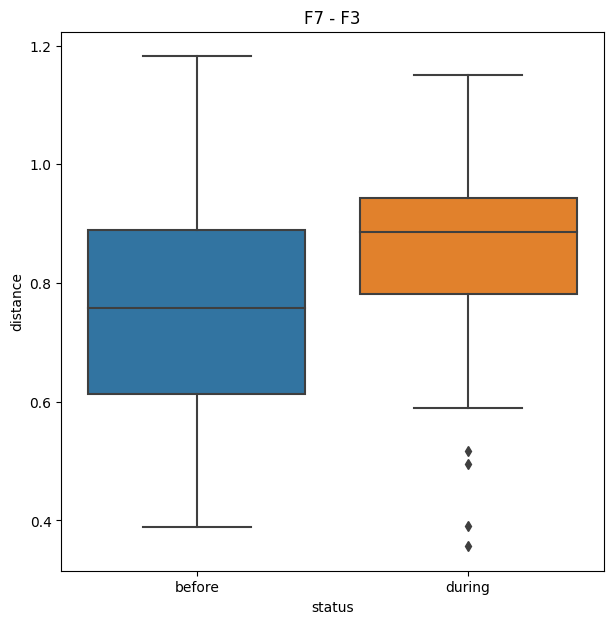

In [140]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_title('F7 - F3')

sns.boxplot(
    df_f7_to_f3, x='status', y='distance', ax=ax
)

plt.show()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


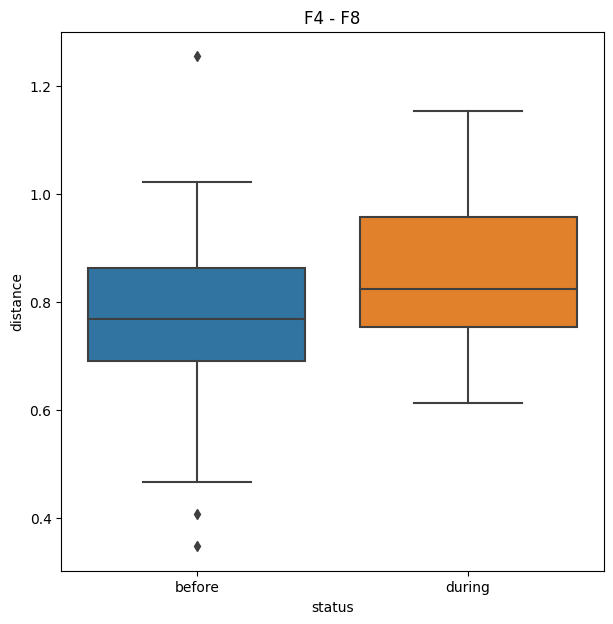

In [141]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_title('F4 - F8')

sns.boxplot(
    df_f4_to_f8, x='status', y='distance', ax=ax
)

plt.show()

# Promedio personas basado en su calidad de conteo - Antes y durante

In [30]:
# Promedio de las personas dependiendo de su calidad de conteo (antes y durante)

ave_b_before, ave_g_before = np.zeros((19, 19)), np.zeros((19, 19))
ave_b_during, ave_g_during = np.zeros((19, 19)), np.zeros((19, 19))
n_b, n_g = 0, 0

for i in range(35 + 1):
    subject = f'Subject{i:02}'
    csv_path1 = f'Archivos\\{subject}\\csv\\{subject}_1.csv'
    csv_path2 = f'Archivos\\{subject}\\csv\\{subject}_2.csv'

    if df_subject_info['Count quality'][i] == 1:
        ave_g_before += get_distances(csv_path1)
        ave_g_during += get_distances(csv_path2)
        n_g += 1
    else:
        ave_b_before += get_distances(csv_path1)
        ave_b_during += get_distances(csv_path2)
        n_b += 1

ave_g_before /= n_g
ave_g_during /= n_g
ave_b_before /= n_b
ave_b_during /= n_b

df_centrality_ave_g_before = get_centrality_from_df(ave_g_before)
df_centrality_ave_g_during = get_centrality_from_df(ave_g_during)
df_centrality_ave_b_before = get_centrality_from_df(ave_b_before)
df_centrality_ave_b_during = get_centrality_from_df(ave_b_during)

df_centrality_ave_g_before['status'] = 'before'
df_centrality_ave_g_during['status'] = 'during'
df_centrality_ave_b_before['status'] = 'before'
df_centrality_ave_b_during['status'] = 'during'

df_centrality_ave_g = pd.concat([df_centrality_ave_g_before, df_centrality_ave_g_during], ignore_index=True)
df_centrality_ave_b = pd.concat([df_centrality_ave_b_before, df_centrality_ave_b_during], ignore_index=True)

ave_g_before.to_csv('Archivos\\ave_distances_good_before.csv', sep=';', index=False)
ave_b_before.to_csv('Archivos\\ave_distances_bad_before.csv', sep=';', index=False)
ave_g_during.to_csv('Archivos\\ave_distances_good_during.csv', sep=';', index=False)
ave_b_during.to_csv('Archivos\\ave_distances_bad_during.csv', sep=';', index=False)

df_centrality_ave_g.to_csv('Archivos\\ave_centrality_good.csv', sep=';', index=False)
df_centrality_ave_b.to_csv('Archivos\\ave_centrality_bad.csv', sep=';', index=False)

In [15]:
df_centrality_ave_g = pd.read_csv('Archivos\\ave_centrality_good.csv', delimiter=';')
df_centrality_ave_b = pd.read_csv('Archivos\\ave_centrality_bad.csv', delimiter=';')

df_centrality_ave_g['Count quality'] = 'G'
df_centrality_ave_b['Count quality'] = 'B'

df_centrality_ave_counts = pd.concat([df_centrality_ave_b, df_centrality_ave_g], ignore_index=True)

df_centrality_ave_g_before = df_centrality_ave_g[df_centrality_ave_g['status'] == 'before']
df_centrality_ave_b_before = df_centrality_ave_b[df_centrality_ave_b['status'] == 'before']
df_centrality_ave_g_during = df_centrality_ave_g[df_centrality_ave_g['status'] == 'during'].reset_index(drop=True)
df_centrality_ave_b_during = df_centrality_ave_b[df_centrality_ave_b['status'] == 'during'].reset_index(drop=True)

ave_g_before = pd.read_csv('Archivos\\ave_distances_good_before.csv', delimiter=';')
ave_g_before.index = CHANNELS

ave_b_before = pd.read_csv('Archivos\\ave_distances_bad_before.csv', delimiter=';')
ave_b_before.index = CHANNELS

ave_g_during = pd.read_csv('Archivos\\ave_distances_good_during.csv', delimiter=';')
ave_g_during.index = CHANNELS

ave_b_during = pd.read_csv('Archivos\\ave_distances_bad_during.csv', delimiter=';')
ave_b_during.index = CHANNELS

In [16]:
mst_ave_g_before = get_mst_from_df(ave_g_before)
mst_ave_g_during = get_mst_from_df(ave_g_during)
mst_ave_b_before = get_mst_from_df(ave_b_before)
mst_ave_b_during = get_mst_from_df(ave_b_during)

for i, node in enumerate(CHANNELS):
    mst_ave_g_before.nodes[node]['degree'] = round(df_centrality_ave_g_before['degree'][i], 2)
    mst_ave_g_before.nodes[node]['betweenness'] = round(df_centrality_ave_g_before['betweenness'][i], 2)
    mst_ave_g_before.nodes[node]['closeness'] = round(df_centrality_ave_g_before['closeness'][i], 2)
    mst_ave_g_before.nodes[node]['pagerank'] = round(df_centrality_ave_g_before['pagerank'][i], 2)

    mst_ave_g_during.nodes[node]['degree'] = round(df_centrality_ave_g_during['degree'][i], 2)
    mst_ave_g_during.nodes[node]['betweenness'] = round(df_centrality_ave_g_during['betweenness'][i], 2)
    mst_ave_g_during.nodes[node]['closeness'] = round(df_centrality_ave_g_during['closeness'][i], 2)
    mst_ave_g_during.nodes[node]['pagerank'] = round(df_centrality_ave_g_during['pagerank'][i], 2)

    mst_ave_b_before.nodes[node]['degree'] = round(df_centrality_ave_b_before['degree'][i], 2)
    mst_ave_b_before.nodes[node]['betweenness'] = round(df_centrality_ave_b_before['betweenness'][i], 2)
    mst_ave_b_before.nodes[node]['closeness'] = round(df_centrality_ave_b_before['closeness'][i], 2)
    mst_ave_b_before.nodes[node]['pagerank'] = round(df_centrality_ave_b_before['pagerank'][i], 2)

    mst_ave_b_during.nodes[node]['degree'] = round(df_centrality_ave_b_during['degree'][i], 2)
    mst_ave_b_during.nodes[node]['betweenness'] = round(df_centrality_ave_b_during['betweenness'][i], 2)
    mst_ave_b_during.nodes[node]['closeness'] = round(df_centrality_ave_b_during['closeness'][i], 2)
    mst_ave_b_during.nodes[node]['pagerank'] = round(df_centrality_ave_b_during['pagerank'][i], 2)

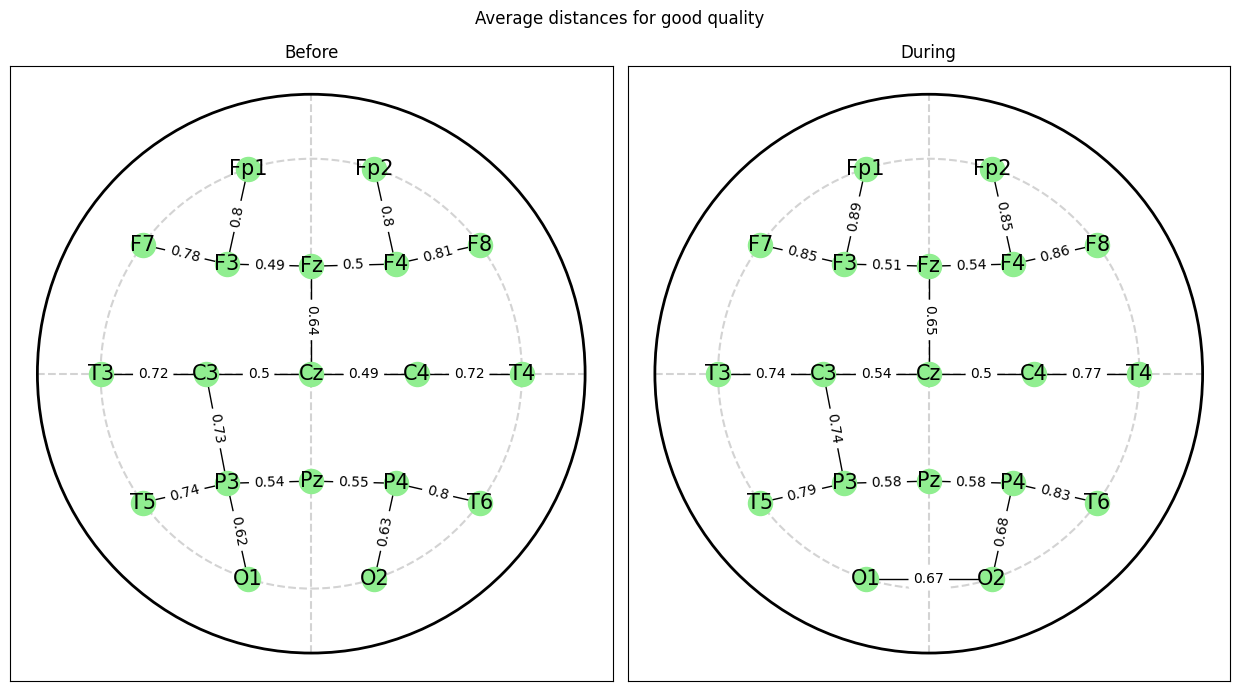

In [18]:
# MST para todos los buenos antes y durante

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 7))
fig.suptitle('Average distances for good quality')

for ax in (ax1, ax2):
    ax.add_patch(Circle((0, 0), radius=1, color='lightgray', fill=False, linestyle='--', linewidth=1.5))
    ax.add_patch(Circle((0, 0), radius=1.3, color='black', fill=False, linewidth=2))

    # Agregar segmentos
    ax.plot([0, 0], [-1.3, 1.3], linestyle='--', color='lightgray', linewidth=1.5, zorder=0)
    ax.plot([-1.3, 1.3], [0, 0], linestyle='--', color='lightgray', linewidth=1.5, zorder=0)

ax1.set_title('Before')
nx.draw_networkx(
    mst_ave_g_before,
    pos,
    ax = ax1,
    font_size=15,
    node_color='lightgreen'
)

nx.draw_networkx_edge_labels(
    mst_ave_g_before,
    pos,
    {pair: round(weight, 2) for pair, weight in nx.get_edge_attributes(mst_ave_g_before, 'weight').items()},
    ax=ax1
)

ax2.set_title('During')
nx.draw_networkx(
    mst_ave_g_during,
    pos,
    ax=ax2,
    font_size=15,
    node_color='lightgreen'
)

nx.draw_networkx_edge_labels(
    mst_ave_g_during,
    pos,
    {pair: round(weight, 2) for pair, weight in nx.get_edge_attributes(mst_ave_g_during, 'weight').items()},
    ax=ax2
)

plt.tight_layout()
plt.show()

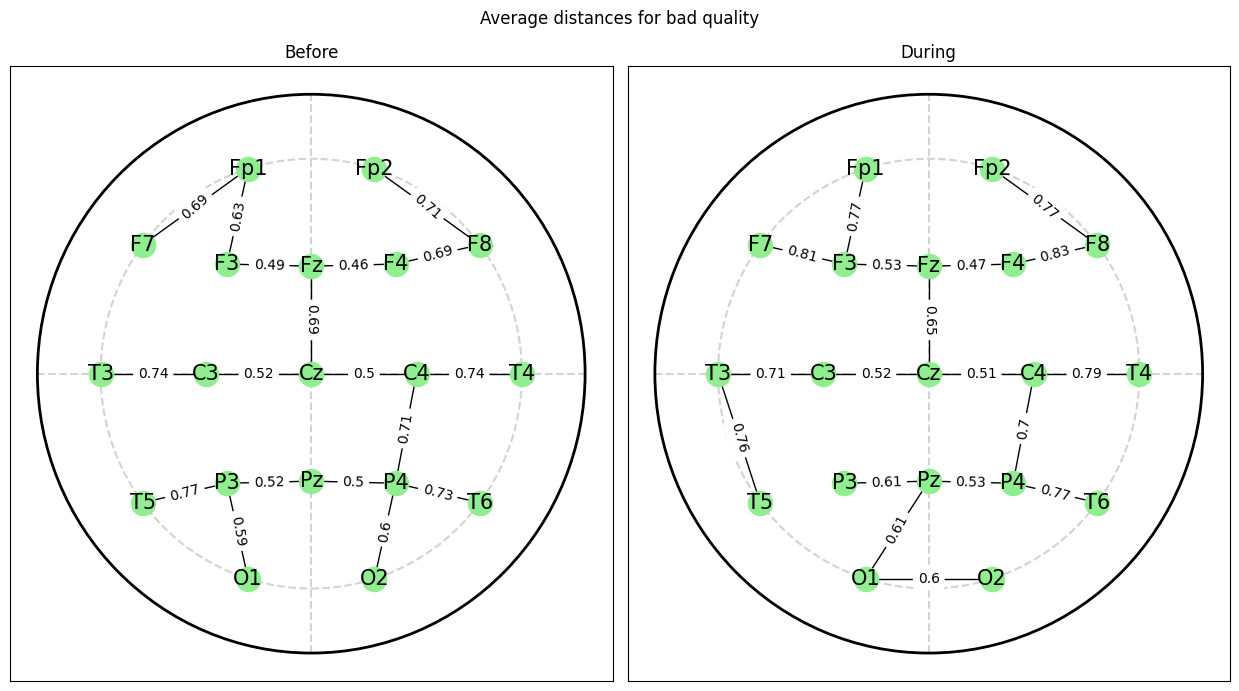

In [19]:
# MST para todos los buenos antes y durante

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 7))
fig.suptitle('Average distances for bad quality')

for ax in (ax1, ax2):
    ax.add_patch(Circle((0, 0), radius=1, color='lightgray', fill=False, linestyle='--', linewidth=1.5))
    ax.add_patch(Circle((0, 0), radius=1.3, color='black', fill=False, linewidth=2))

    # Agregar segmentos
    ax.plot([0, 0], [-1.3, 1.3], linestyle='--', color='lightgray', linewidth=1.5, zorder=0)
    ax.plot([-1.3, 1.3], [0, 0], linestyle='--', color='lightgray', linewidth=1.5, zorder=0)

ax1.set_title('Before')
nx.draw_networkx(
    mst_ave_b_before,
    pos,
    ax = ax1,
    font_size=15,
    node_color='lightgreen'
)

nx.draw_networkx_edge_labels(
    mst_ave_b_before,
    pos,
    {pair: round(weight, 2) for pair, weight in nx.get_edge_attributes(mst_ave_b_before, 'weight').items()},
    ax=ax1
)

ax2.set_title('During')
nx.draw_networkx(
    mst_ave_b_during,
    pos,
    ax=ax2,
    font_size=15,
    node_color='lightgreen'
)

nx.draw_networkx_edge_labels(
    mst_ave_b_during,
    pos,
    {pair: round(weight, 2) for pair, weight in nx.get_edge_attributes(mst_ave_b_during, 'weight').items()},
    ax=ax2
)

plt.tight_layout()
plt.show()

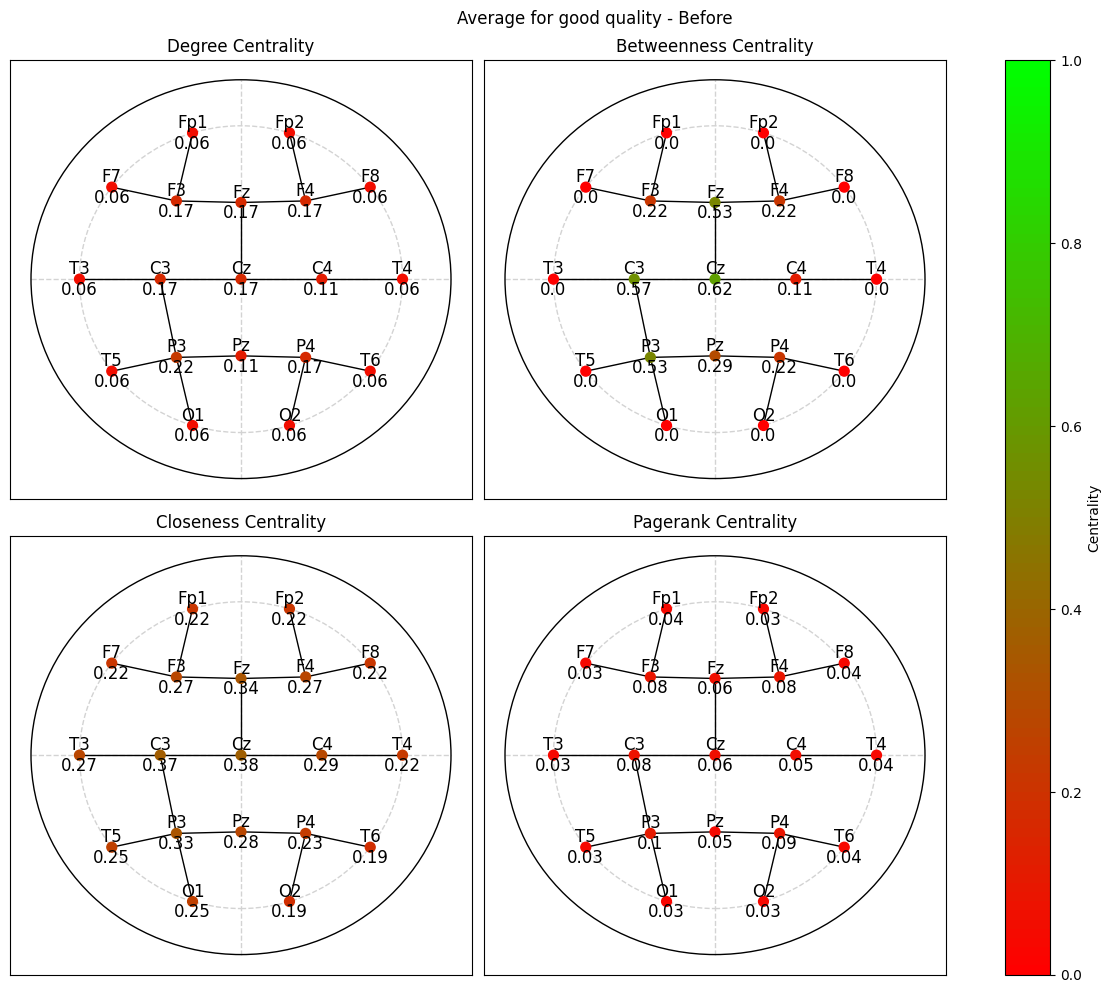

In [20]:
# Promedio de todos los buenos - antes

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Define un mapa de colores personalizado para el degradado (rojo a verde)
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#FF0000', '#00FF00'], N=100)

# Función para asignar un color en función de la medida de centralidad
def get_node_color(i: int, measure: str) -> tuple:
    measure_centrality = df_centrality_ave_g_before.get(measure)
    return cmap(measure_centrality[i])

def plot_measure(G, measure, ax) -> None:
    # En caso de querer ver los nodos y la medida de centralidad
    temp_labels = {node: f'{node}\n{temp_centrality[measure]}' for node, temp_centrality in G.nodes(data=True)}

    ax.add_patch(Circle((0, 0), radius=1.3, color='black', fill=False, linewidth=1))
    ax.add_patch(Circle((0, 0), radius=1, color='lightgray', fill=False, linestyle='--', linewidth=1))

    # Agregar segmentos
    ax.plot([0, 0], [-1.3, 1.3], linestyle='--', color='lightgray', linewidth=1, zorder=0)
    ax.plot([-1.3, 1.3], [0, 0], linestyle='--', color='lightgray', linewidth=1, zorder=0)

    nx.draw_networkx(
        G,
        pos,
        node_size=50,
        with_labels=True,
        ax=ax,
        node_color=[get_node_color(i, measure) for i, _ in enumerate(G.nodes())],
        labels=temp_labels
    )
    
    ax.set_title(f'{measure.title()} Centrality')

# Degree
plot_measure(mst_ave_g_before, 'degree', ax1)

# Betweenness
plot_measure(mst_ave_g_before, 'betweenness', ax2)

# Closeness
plot_measure(mst_ave_g_before, 'closeness', ax3)

# Pagerank
plot_measure(mst_ave_g_before, 'pagerank', ax4)

fig.suptitle('Average for good quality - Before')

plt.tight_layout()

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
plt.colorbar(sm, label='Centrality', ax=(ax1, ax2, ax3, ax4))

plt.show()

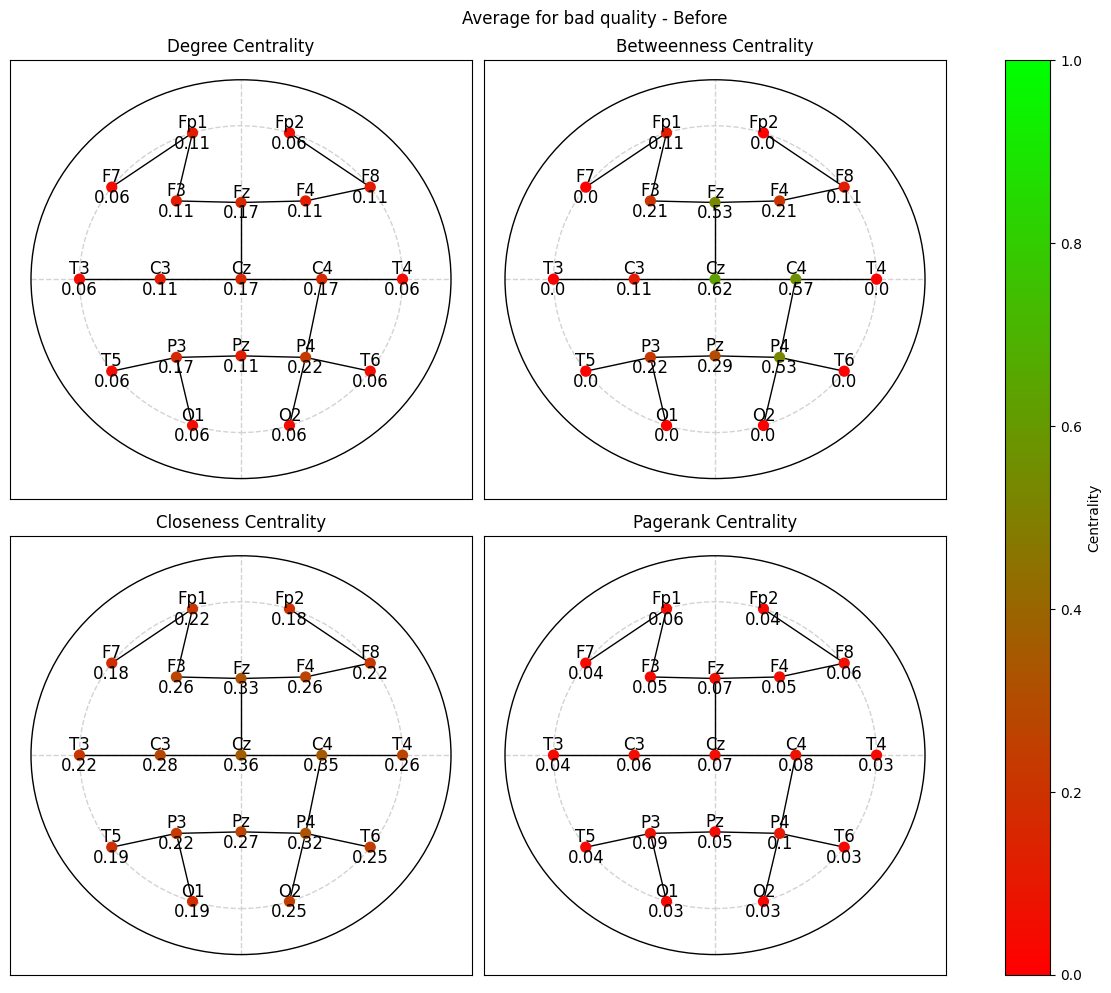

In [21]:
# Promedio de todos los malos - antes

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Define un mapa de colores personalizado para el degradado (rojo a verde)
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#FF0000', '#00FF00'], N=100)

# Función para asignar un color en función de la medida de centralidad
def get_node_color(i: int, measure: str) -> tuple:
    measure_centrality = df_centrality_ave_b_before.get(measure)
    return cmap(measure_centrality[i])

def plot_measure(G, measure, ax) -> None:
    # En caso de querer ver los nodos y la medida de centralidad
    temp_labels = {node: f'{node}\n{temp_centrality[measure]}' for node, temp_centrality in G.nodes(data=True)}

    ax.add_patch(Circle((0, 0), radius=1.3, color='black', fill=False, linewidth=1))
    ax.add_patch(Circle((0, 0), radius=1, color='lightgray', fill=False, linestyle='--', linewidth=1))

    # Agregar segmentos
    ax.plot([0, 0], [-1.3, 1.3], linestyle='--', color='lightgray', linewidth=1, zorder=0)
    ax.plot([-1.3, 1.3], [0, 0], linestyle='--', color='lightgray', linewidth=1, zorder=0)

    nx.draw_networkx(
        G,
        pos,
        node_size=50,
        with_labels=True,
        ax=ax,
        node_color=[get_node_color(i, measure) for i, _ in enumerate(G.nodes())],
        labels=temp_labels
    )
    
    ax.set_title(f'{measure.title()} Centrality')

# Degree
plot_measure(mst_ave_b_before, 'degree', ax1)

# Betweenness
plot_measure(mst_ave_b_before, 'betweenness', ax2)

# Closeness
plot_measure(mst_ave_b_before, 'closeness', ax3)

# Pagerank
plot_measure(mst_ave_b_before, 'pagerank', ax4)

fig.suptitle('Average for bad quality - Before')

plt.tight_layout()

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
plt.colorbar(sm, label='Centrality', ax=(ax1, ax2, ax3, ax4))

plt.show()

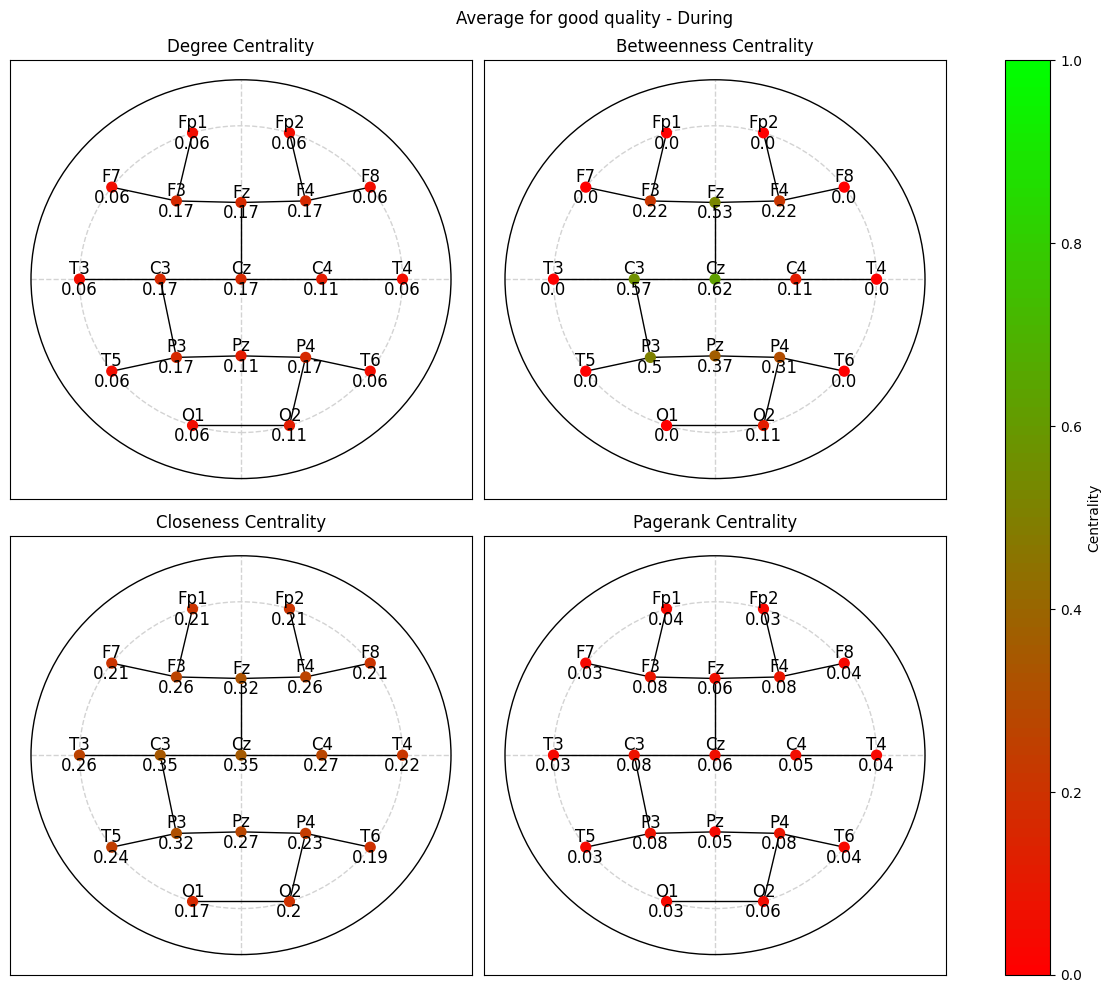

In [22]:
# Promedio de todos los buenos - durante

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Define un mapa de colores personalizado para el degradado (rojo a verde)
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#FF0000', '#00FF00'], N=100)

# Función para asignar un color en función de la medida de centralidad
def get_node_color(i: int, measure: str) -> tuple:
    measure_centrality = df_centrality_ave_g_during.get(measure)
    return cmap(measure_centrality[i])

def plot_measure(G, measure, ax) -> None:
    # En caso de querer ver los nodos y la medida de centralidad
    temp_labels = {node: f'{node}\n{temp_centrality[measure]}' for node, temp_centrality in G.nodes(data=True)}

    ax.add_patch(Circle((0, 0), radius=1.3, color='black', fill=False, linewidth=1))
    ax.add_patch(Circle((0, 0), radius=1, color='lightgray', fill=False, linestyle='--', linewidth=1))

    # Agregar segmentos
    ax.plot([0, 0], [-1.3, 1.3], linestyle='--', color='lightgray', linewidth=1, zorder=0)
    ax.plot([-1.3, 1.3], [0, 0], linestyle='--', color='lightgray', linewidth=1, zorder=0)

    nx.draw_networkx(
        G,
        pos,
        node_size=50,
        with_labels=True,
        ax=ax,
        node_color=[get_node_color(i, measure) for i, _ in enumerate(G.nodes())],
        labels=temp_labels
    )
    
    ax.set_title(f'{measure.title()} Centrality')

# Degree
plot_measure(mst_ave_g_during, 'degree', ax1)

# Betweenness
plot_measure(mst_ave_g_during, 'betweenness', ax2)

# Closeness
plot_measure(mst_ave_g_during, 'closeness', ax3)

# Pagerank
plot_measure(mst_ave_g_during, 'pagerank', ax4)

fig.suptitle('Average for good quality - During')

plt.tight_layout()

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
plt.colorbar(sm, label='Centrality', ax=(ax1, ax2, ax3, ax4))

plt.show()

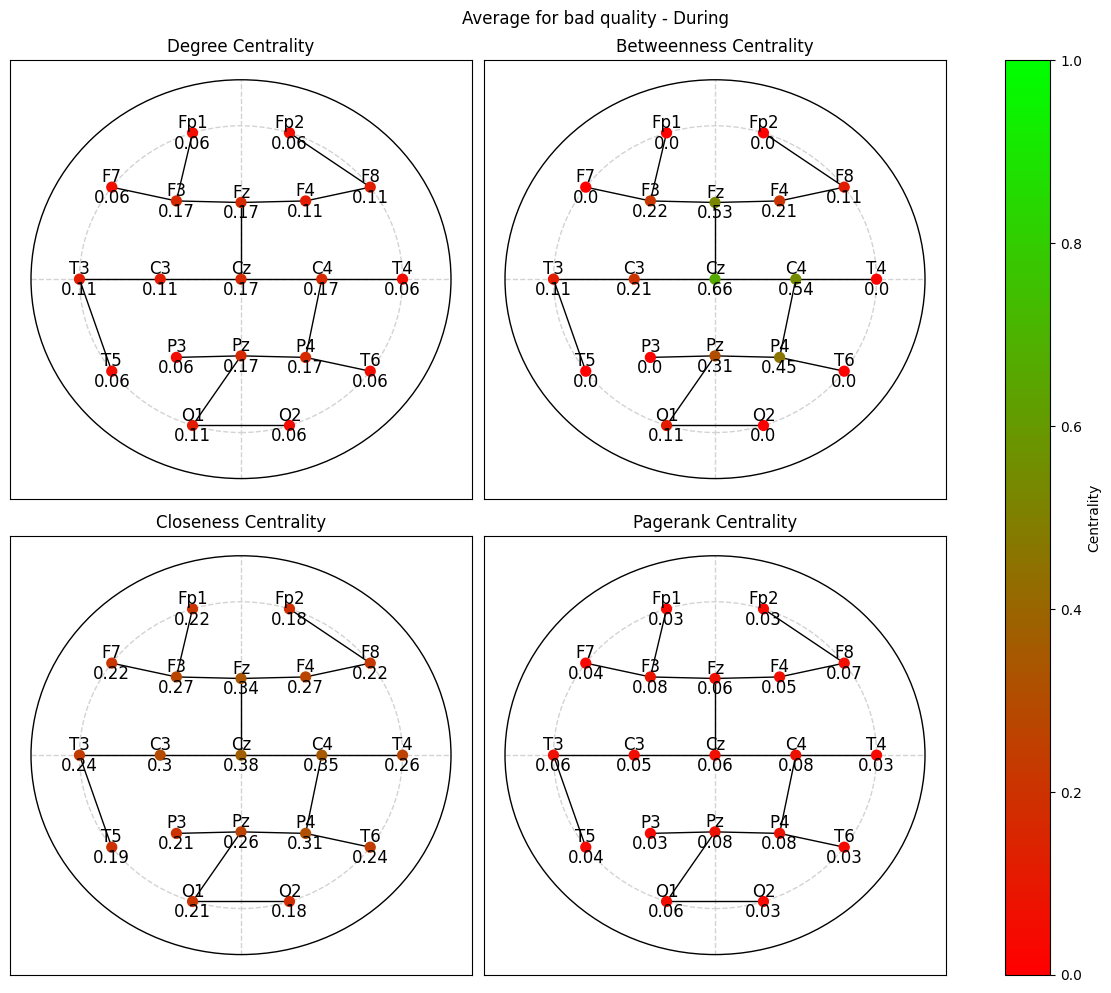

In [23]:
# Promedio de todos los malos - durante

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Define un mapa de colores personalizado para el degradado (rojo a verde)
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#FF0000', '#00FF00'], N=100)

# Función para asignar un color en función de la medida de centralidad
def get_node_color(i: int, measure: str) -> tuple:
    measure_centrality = df_centrality_ave_b_during.get(measure)
    return cmap(measure_centrality[i])

def plot_measure(G, measure, ax) -> None:
    # En caso de querer ver los nodos y la medida de centralidad
    temp_labels = {node: f'{node}\n{temp_centrality[measure]}' for node, temp_centrality in G.nodes(data=True)}

    ax.add_patch(Circle((0, 0), radius=1.3, color='black', fill=False, linewidth=1))
    ax.add_patch(Circle((0, 0), radius=1, color='lightgray', fill=False, linestyle='--', linewidth=1))

    # Agregar segmentos
    ax.plot([0, 0], [-1.3, 1.3], linestyle='--', color='lightgray', linewidth=1, zorder=0)
    ax.plot([-1.3, 1.3], [0, 0], linestyle='--', color='lightgray', linewidth=1, zorder=0)

    nx.draw_networkx(
        G,
        pos,
        node_size=50,
        with_labels=True,
        ax=ax,
        node_color=[get_node_color(i, measure) for i, _ in enumerate(G.nodes())],
        labels=temp_labels
    )
    
    ax.set_title(f'{measure.title()} Centrality')

# Degree
plot_measure(mst_ave_b_during, 'degree', ax1)

# Betweenness
plot_measure(mst_ave_b_during, 'betweenness', ax2)

# Closeness
plot_measure(mst_ave_b_during, 'closeness', ax3)

# Pagerank
plot_measure(mst_ave_b_during, 'pagerank', ax4)

fig.suptitle('Average for bad quality - During')

plt.tight_layout()

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
plt.colorbar(sm, label='Centrality', ax=(ax1, ax2, ax3, ax4))

plt.show()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

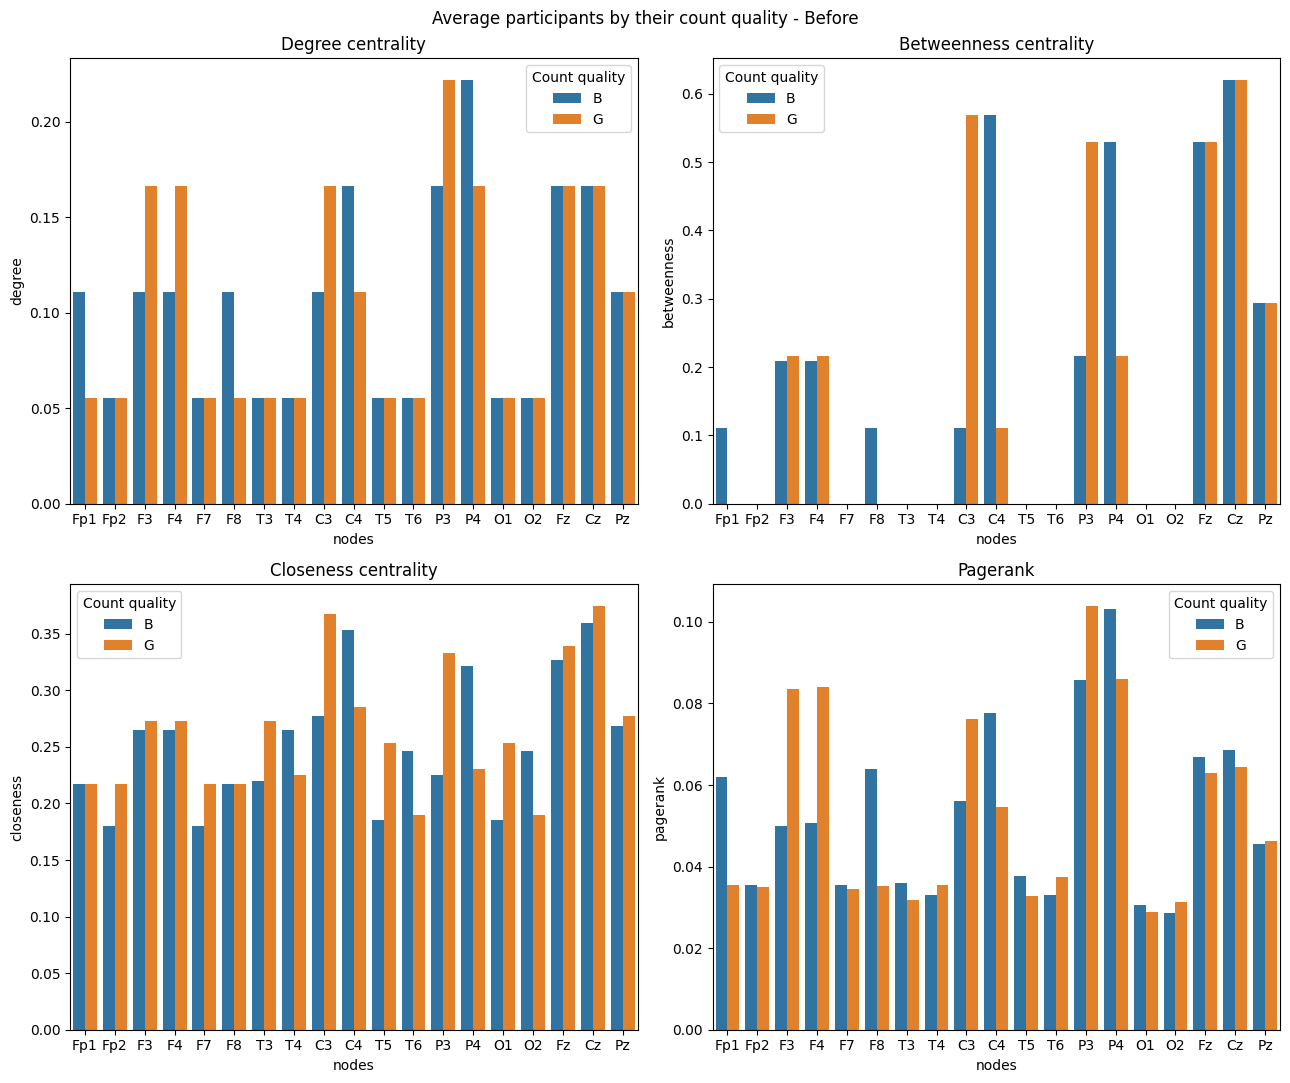

In [189]:
df_temp1 = df_centrality_ave_counts[df_centrality_ave_counts['status'] == 'before']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('Average participants by their count quality - Before')

ax1.set_title('Degree centrality')
sns.barplot(
    df_temp1, x='nodes', y='degree', hue='Count quality', ax=ax1
)

ax2.set_title('Betweenness centrality')
sns.barplot(    
    df_temp1, x='nodes', y='betweenness', hue='Count quality', ax=ax2
)

ax3.set_title('Closeness centrality')
sns.barplot(
    df_temp1, x='nodes', y='closeness', hue='Count quality', ax=ax3
)

ax4.set_title('Pagerank')
sns.barplot(
    df_temp1, x='nodes', y='pagerank', hue='Count quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

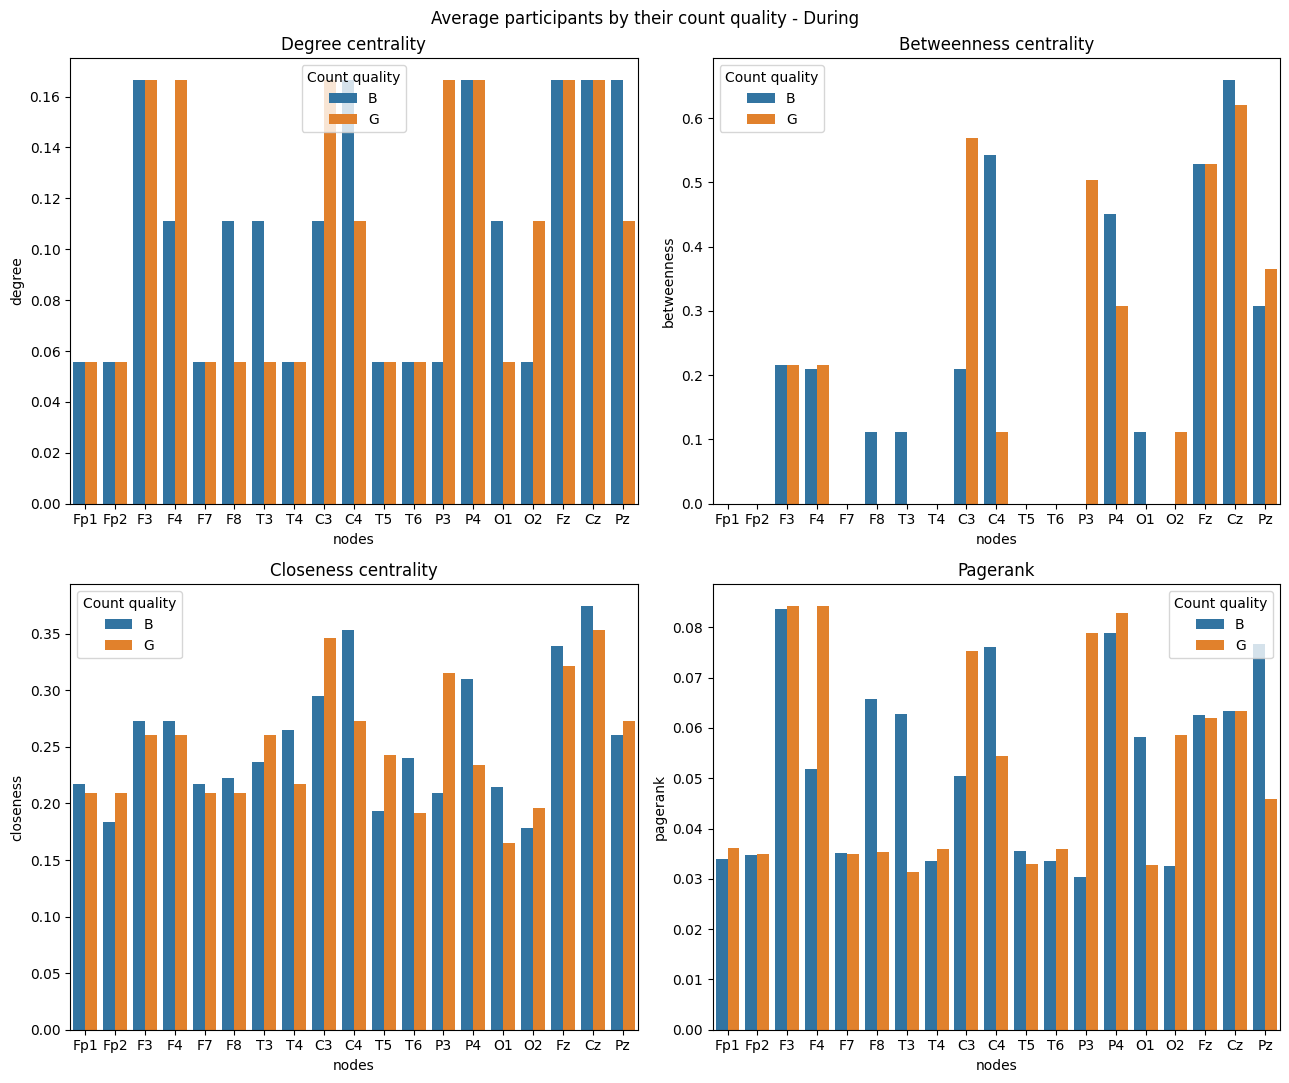

In [190]:
df_temp1 = df_centrality_ave_counts[df_centrality_ave_counts['status'] == 'during']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('Average participants by their count quality - During')

ax1.set_title('Degree centrality')
sns.barplot(
    df_temp1, x='nodes', y='degree', hue='Count quality', ax=ax1
)

ax2.set_title('Betweenness centrality')
sns.barplot(
    df_temp1, x='nodes', y='betweenness', hue='Count quality', ax=ax2
)

ax3.set_title('Closeness centrality')
sns.barplot(
    df_temp1, x='nodes', y='closeness', hue='Count quality', ax=ax3
)

ax4.set_title('Pagerank')
sns.barplot(
    df_temp1, x='nodes', y='pagerank', hue='Count quality', ax=ax4
)

plt.tight_layout()

# Mapa topográfico

In [76]:
from ipywidgets import interact, FloatSlider
from IPython.display import display

In [85]:
N = 36

ave = np.zeros((19, 122000), dtype=float)
for i in range(N):
    subject = f'Subject{i:02}'
    edf_path1 = f'Archivos\\{subject}\\edf\\{subject}_1.edf'
    edf_path2 = f'Archivos\\{subject}\\edf\\{subject}_2.edf'

    raw_before = mne.io.read_raw_edf(edf_path1)
    raw_during = mne.io.read_raw_edf(edf_path2)

    raw = mne.concatenate_raws([raw_before, raw_during])

    # Obtener los electrodos relevantes
    raw.drop_channels(['EEG A2-A1', 'ECG ECG'])
    raw.rename_channels(lambda eeg: eeg.replace('EEG ', ''))

    print(subject)

    ave += raw.get_data()

ave /= N
ave

Extracting EDF parameters from c:\Users\perez\OneDrive\Documentos\vscode\semillero\Archivos\Subject00\edf\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\perez\OneDrive\Documentos\vscode\semillero\Archivos\Subject00\edf\Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Subject00
Extracting EDF parameters from c:\Users\perez\OneDrive\Documentos\vscode\semillero\Archivos\Subject01\edf\Subject01_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\perez\OneDrive\Documentos\vscode\semillero\Archivos\Subject01\edf\Subject01_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Subject01
Extracting EDF parameters from c:\Users\perez\OneDrive\Documentos\vscode\semillero\Archivos\Subject02\edf\Subject02_1.edf...
EDF file detected
Setti

ValueError: operands could not be broadcast together with shapes (19,122000) (19,116000) (19,122000) 

In [204]:
subject = 'Subject35'
edf_path1 = f'Archivos\\{subject}\\edf\\{subject}_1.edf'
edf_path2 = f'Archivos\\{subject}\\edf\\{subject}_2.edf'

raw_before = mne.io.read_raw_edf(edf_path1)
raw_during = mne.io.read_raw_edf(edf_path2)

raw = mne.concatenate_raws([raw_before, raw_during])

raw

Extracting EDF parameters from c:\Users\perez\OneDrive\Documentos\vscode\semillero\Archivos\Subject35\edf\Subject35_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\perez\OneDrive\Documentos\vscode\semillero\Archivos\Subject35\edf\Subject35_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<RawEDF | Subject35_1.edf, 21 x 122000 (244.0 s), ~21 kB, data not loaded>

In [95]:
raw_0 = mne.io.read_raw_edf(r'Archivos\Subject04\edf\Subject04_1.edf')
raw_1 = mne.io.read_raw_edf(r'Archivos\Subject04\edf\Subject04_2.edf')

raw = mne.concatenate_raws([raw_0, raw_1], preload=True)

# Obtener los electrodos relevantes
raw.drop_channels(['EEG A2-A1', 'ECG ECG'])
raw.rename_channels(lambda eeg: eeg.replace('EEG ', ''))

raw.get_data().shape

Extracting EDF parameters from c:\Users\perez\OneDrive\Documentos\vscode\semillero\Archivos\Subject04\edf\Subject04_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\perez\OneDrive\Documentos\vscode\semillero\Archivos\Subject04\edf\Subject04_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


(19, 116000)

In [32]:
raw_0 = mne.io.read_raw_edf('Archivos\Subject00\edf\Subject00_1.edf')
raw_1 = mne.io.read_raw_edf('Archivos\Subject00\edf\Subject00_2.edf')

raw = mne.concatenate_raws([raw_0, raw_1], preload=True)

# Obtener los electrodos relevantes
raw.drop_channels(['EEG A2-A1', 'ECG ECG'])
raw.rename_channels(lambda eeg: eeg.replace('EEG ', ''))

evoked: mne.Evoked = mne.EvokedArray(raw.get_data(), info=raw.info)

montage = mne.channels.make_standard_montage("standard_1020")
evoked.info.set_montage(montage)

slider = FloatSlider(value=0, min=0, max=(len(raw.times)-1)*2e-3, step=0.002, description="Seconds")

def plot_topomap(time):
    evoked.plot_topomap(
        times=time, ch_type='eeg', show_names=True, size=5
    )

interact(plot_topomap, time=slider)
display(slider)

Extracting EDF parameters from c:\Users\perez\OneDrive\Documentos\vscode\semillero\Archivos\Subject00\edf\Subject00_1.edf...
EDF file detected


Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\perez\OneDrive\Documentos\vscode\semillero\Archivos\Subject00\edf\Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


interactive(children=(FloatSlider(value=0.0, description='Seconds', max=243.99800000000002, step=0.002), Outpu…

FloatSlider(value=0.0, description='Seconds', max=243.99800000000002, step=0.002)

In [ ]:
slider = FloatSlider(value=0, min=0, max=(len(raw.times)-1)*2e-3, step=0.002, description="Seconds")

def plot_topomap(time):
    evoked.plot_topomap(
        times=time, ch_type='eeg', show_names=True, size=5
    )

interact(plot_topomap, time=slider)
display(slider)

In [77]:
df_1 = pd.read_csv('Archivos\Subject00\csv\Subject00_1.csv', sep=';') * 1e-6
df_2 = pd.read_csv('Archivos\Subject00\csv\Subject00_2.csv', sep=';') * 1e-6

info = mne.create_info(CHANNELS, ch_types=['eeg']*19, sfreq=500)
info.set_montage("standard_1020")

raw_0 = mne.io.RawArray(df_1, info)
raw_1 = mne.io.RawArray(df_2, info)

raw = mne.concatenate_raws([raw_0, raw_1], preload=True)

evoked = mne.EvokedArray(raw.get_data(), info=raw.info)

evoked

Creating RawArray with float64 data, n_channels=19, n_times=91000
    Range : 0 ... 90999 =      0.000 ...   181.998 secs
Ready.
Creating RawArray with float64 data, n_channels=19, n_times=31000
    Range : 0 ... 30999 =      0.000 ...    61.998 secs
Ready.


<Evoked | '' (average, N=1), 0 – 244 s, baseline off, 19 ch, ~17.7 MB>